# Installing and importing the data

In [12]:
!pip install datasets > /dev/null

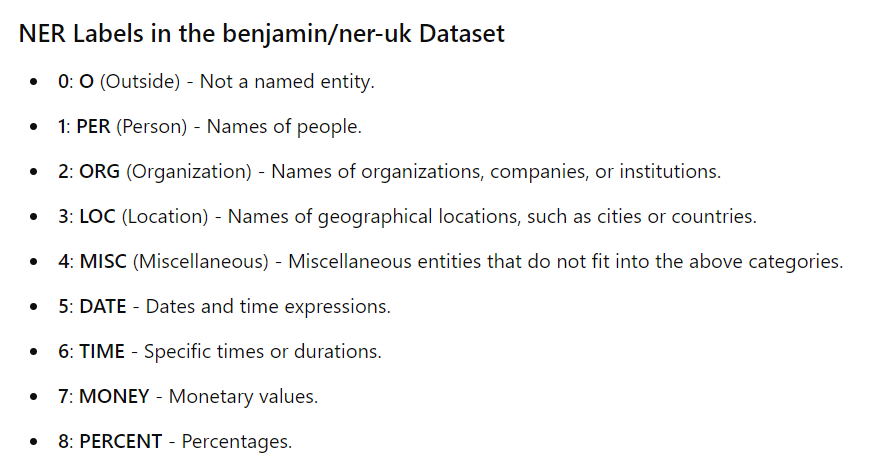

In [2]:
import sys  # System-specific parameters and functions
from typing import List, Tuple, Mapping  # Type hinting for better code readability

# Import datasets library for handling various datasets
import datasets
from tqdm import tqdm  # Progress bar library for iterations
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Plotting library for visualizations

# Import PyTorch for building neural networks
import torch
import torch.nn as nn  # Neural network module
import torch.optim as optim  # Optimizer module from PyTorch for model training
import torch.nn.functional as F  # Functional operations like activation functions and loss calculations

# Importing padding utility for sequence data
from torch.nn.utils.rnn import pad_sequence  # pad_sequence for padding sequences in RNNs
# Dataset and DataLoader for efficient data handling and batching
from torch.utils.data import Dataset, DataLoader

## Dataset

**[HuggingFace](https://huggingface.co/datasets/benjamin/ner-uk)** <br>
**[GitHub](https://github.com/lang-uk/ner-uk/tree/master)**

In [14]:
dataset = datasets.load_dataset("benjamin/ner-uk") # loading dataset

dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10833
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1307
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 668
    })
})

# Exploring and visualizing the data

In [ ]:
# observing one training sample
dataset['train'][22]

{'tokens': ['Натомість',
  'представництва',
  'іноземних',
  'корпорацій',
  'не',
  'могли',
  'відверто',
  'надавати',
  'підтримку',
  'України',
  ',',
  'оскільки',
  'більшість',
  'з',
  'них',
  'робить',
  'бізнес',
  'і',
  'в',
  'Росії',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]}

In [16]:
# NOTE: will use this value for labels padding,
#       CrossEntropyLoss has special parameter called 'ignore_index'
#       and it will ignore labels with this value (loss computation
#       will be ommited for labels that equal to that value)
NER_PAD_ID = -100 # padding for targets. We don't use 0 because it is a common init value and we have a lot of "0" as targets.
# So pick -100 (cause it will not occur in the the target for sure) and tell cross entropy to ignore it i.e.
# the loss function will exclude those elements when computing the loss

# Initialize an empty set to store NERs (targets)
targets = set()

for split in ("train", "validation", "test"):
    for sample in dataset[split]:
        targets.update(sample["ner_tags"]) # Update the 'targets' set with NER tags from the current sample.

# Sort the unique NER tags
targets = sorted(targets)
print("Unique targets:", len(targets))
targets

Unique targets: 9


[0, 1, 2, 3, 4, 5, 6, 7, 8]

# Data preprocessing

In [15]:
TOK_PAD_ID = 0  # Define a token ID for padding input sequences.

vocab = {"<PAD>": TOK_PAD_ID}  # token ID will be used later when processing sequences to pad them to a consistent length
# (the actual padding of sequences occurs during data preprocessing when you convert the text sequences to numerical sequences and create batches for training)
curr_idx = 1

# Iterate through dataset splits (train, validation, test).
for split in ("train", "validation", "test"):
    for sample in dataset[split]:
        # Iterate through words (tokens) in the sample.
        for word in sample["tokens"]:
            # Check if the word is not already in the vocabulary.
            if word not in vocab:
                vocab[word] = curr_idx  # Add the word to the vocabulary with the current index.
                curr_idx += 1  # Increment the current index.

print("Vocab size:", len(vocab))

Vocab size: 50205


## PyTorch Datasets & DataLoaders

In [17]:
class NERDataset(Dataset):
    def __init__(self, samples: datasets.Dataset, vocabulary: Mapping[str, int]) -> None:
        """
        Initialize a Named Entity Recognition (NER) dataset.

        Args:
            samples (datasets.Dataset): The dataset containing samples with tokens and NER tags.
            vocabulary (Mapping[str, int]): A mapping from tokens to their corresponding indices.
        """
        self.samples = samples  # Store the input samples dataset.
        self.vocabulary = vocabulary  # Store the vocabulary for token-to-index mapping.

    def __len__(self) -> int:
        """
        Get the number of samples in the dataset.

        Returns:
            int: The total number of samples in the dataset.
        """
        return len(self.samples)  # Return the number of samples in the dataset.

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        """
        Retrieve a sample and its corresponding NER tags by index.

        Args:
            index (int): The index of the desired sample.

        Returns:
            Tuple[torch.LongTensor, torch.LongTensor]: A tuple containing token indices and NER tags.
        """
        sample = self.samples[index]  # Get the sample at the specified index.

        # Convert tokens to their corresponding indices using the vocabulary.
        doc = torch.LongTensor([self.vocabulary[token] for token in sample["tokens"]])  # Convert tokens to LongTensor indices.

        # Convert NER tags to a tensor of Long values.
        label = torch.LongTensor(sample["ner_tags"])  # Convert NER tags to LongTensor.

        return doc, label  # Return the token indices and NER tags for the sample.

## Creating and testing batch generators

In [18]:
def seq_collate_fn(
    batch: List[Tuple[torch.LongTensor, torch.LongTensor]], data_pad: int, label_pad: int
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Combine samples into batch that can be used later by RNN model.

    Args:
        batch: list with tensors that should be packed into batch.
            Expected that each list sample will be a tuple of (text_tokens, label_tokens).
        data_pad: value to use for padding text tokens.
        label_pad: value to use for padding label tokens.

    Returns:
        Padded and packed into batch text tokens and padded and packed into batch label tokens.
    """
    token_ids = pad_sequence([item[0] for item in batch], batch_first=True, padding_value=data_pad) # because sentences and labels have different length, we pad empty slots with "data_pad" values)
    label_ids = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=label_pad)
    return token_ids, label_ids


def ner_collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]]) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Collator function for our NER dataset.

    Args:
        batch: list with tensors that should be packed into batch.
            Expected that each list sample will be a tuple of (text_tokens, label_tokens).

    Returns:
        Padded and packed into batch text tokens and padded and packed into batch label tokens.
    """
    return seq_collate_fn(batch, TOK_PAD_ID, NER_PAD_ID)

In [19]:
# creating custom dataset objects
train_dataset = NERDataset(dataset["train"], vocab)
validation_dataset = NERDataset(dataset["validation"], vocab)
test_dataset = NERDataset(dataset["test"], vocab)

len(train_dataset), len(validation_dataset), len(test_dataset)

(10833, 1307, 668)

In [20]:
ner_collate_fn([train_dataset[0], train_dataset[1], train_dataset[2]])

(tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
           0,  0,  0,  0],
         [19, 20, 21,  2, 22, 23, 24, 25, 26,  8, 27, 28, 29, 30, 31,  2, 32,  2,
           9, 33, 34, 18],
         [35, 36, 37,  3, 38, 39, 40, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]]),
 tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0, -100, -100, -100, -100],
         [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
         [   0,    0,    0,    0,    0,    0,    0,    0, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]]))

In [ ]:
train_dataset[19] # 19th samle contains tensor of inputs and targets

(tensor([216, 217, 218, 219,  42, 220, 221, 222, 161, 223, 224,  61,  18]),
 tensor([0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

# Researching the dataset imbalances

In [21]:
# Count the number of TOK_PAD_ID tokens in the training dataset after padding
tok_pad_count = 0
non_tok_pad_count = 0

# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=ner_collate_fn)

for x_batch, _ in train_loader:
    # Count the occurrences of TOK_PAD_ID and non-TOK_PAD_ID in the padded batch
    tok_pad_count += (x_batch == TOK_PAD_ID).sum().item()
    non_tok_pad_count += (x_batch != TOK_PAD_ID).sum().item()

print(f"Number of TOK_PAD_ID tokens in the training dataset: {tok_pad_count}")
print(f"Number of NON-TOK_PAD_ID tokens in the training dataset: {non_tok_pad_count}")

Number of TOK_PAD_ID tokens in the training dataset: 438371
Number of NON-TOK_PAD_ID tokens in the training dataset: 202073


In [22]:
# Initialize a dictionary to hold the count of each class in the dataset
counts = {cls: 0 for cls in targets}

# Iterate over batches in the training data loader
for x_batch, _ in train_loader:
    # For each class in the defined targets
    for cls in targets:
        # Count occurrences of the class in the current batch and update the counts dictionary
        counts[cls] += (x_batch == cls).sum().item()

# Print the counts of each class
print(counts)

{0: 438371, 1: 6, 2: 18797, 3: 1999, 4: 13, 5: 6, 6: 24, 7: 6, 8: 8}


## Preparation to the training

In [ ]:
# construct DataLoaders from datasets, pad data, divide it into batches, shuffle it, drop last if length is inconsistent (remaining size is smaller than the specified batch_size)
batch_size = 64

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True, # whether it should be shuffled at the beginning of each epoch
                          drop_last=True, # whether to drop the last incomplete batch
                          collate_fn=ner_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)

len(train_loader), len(validation_loader), len(test_loader)

(169, 21, 11)

In [ ]:
next(iter(train_loader))[1].shape # a batch size of 64, and each sequence (sentence) in the batch has 55 elements

torch.Size([64, 148])

# Training & Evaluation

## Creating a custom F1-score metric

In [23]:
def sequence_f1(true_labels: np.array, predicted_labels: np.array) -> np.array:
    """F1 score for one sequence.

    Args:
        true_labels: ground truth labels.
        predicted_labels: model predictions.

    Returns:
        F1 scores for each class.
    """
    assert len(true_labels) == len(predicted_labels), "Mismatched length between true labels and predicted labels"

    scores = []
    for _cls in targets:
        # The number of correct positive predictions (the model correctly identified a positive instance as positive)
        true_positives = np.sum((true_labels == predicted_labels) & (true_labels == _cls))
        # The number of incorrect positive predictions made by the model (the model incorrectly identified a negative instance as positive).
        false_positives = np.sum((true_labels != predicted_labels) & (predicted_labels == _cls))
        # The number of missed positive predictions (the model incorrectly identified a positive instance as negative).
        false_negatives = np.sum((true_labels != predicted_labels) & (true_labels == _cls))

        # how many positives were in fact positives
        precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
        # how many positives identified in regards to how many actually is
        recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
        # harmonic mean between precision and recall
        f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)

        scores.append(f1_score)
    return np.array(scores)

## Train method

In [24]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> Mapping[str, np.array]:
    """Train model one epoch.

    Args:
        model: model to train.
        loader: dataloader to use for training.
        criterion: loss function to optimize.
        optimizer: model training algorithm.
        device: device to use for training.
            Default is `"cpu"`.
        verbose: option to print training progress bar.
            Default is `True`.

    Returns:
        dict with training logs
    """
    model.train()

    losses = []
    scores = []

    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            x_batch = x_batch.to(device)  # long tensor [B, T]
            y_true = y_true.to(device)    # long tensor [B, T]

            optimizer.zero_grad()

            log_prob = model(x_batch)

            B, T = y_true.shape
            loss = criterion(log_prob.view(B * T, -1), y_true.view(B * T))

            loss.backward()
            losses.append(loss.item())

            y_pred = log_prob.argmax(2).detach().cpu().numpy()
            y_true = y_true.detach().cpu().numpy()
            padding_mask = y_true != NER_PAD_ID
            for i in range(x_batch.size(0)):
                scores.append(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]]))

            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            optimizer.step()

            progress.update(1)

    logs = {
        "losses": np.array(losses),
        "f1": np.array(scores)
    }
    return logs

# Evaluation method

In [25]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> Mapping[str, np.array]:
    """Model evaluation.

    Args:
        model: model to evaluate.
        loader: dataloader to use for evaluation.
        criterion: loss function.
        device: device to use for evaluation.
            Default is `"cpu"`.
        verbose: option to print evaluation progress bar.
            Default is `True`.

    Returns:
        dict with evaluation logs
    """
    model.eval()

    losses = []
    scores = []

    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        x_batch = x_batch.to(device)  # long tensor [B, T]
        y_true = y_true.to(device)    # long tensor [B, T]

        log_prob = model(x_batch)

        B, T = y_true.shape
        loss = criterion(log_prob.view(B * T, -1), y_true.view(B * T))

        losses.append(loss.item())

        y_pred = log_prob.argmax(2).detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()
        padding_mask = y_true != NER_PAD_ID
        for i in range(x_batch.size(0)):
            scores.append(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]]))


    logs = {
        "losses": np.array(losses),
        "f1": np.array(scores)
    }
    return logs

## Setting up the simplest versions of the models being tested: RNN; GRU; LSTM.

In [26]:
# architecture for GRU
class NER_GRU(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_GRU, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.GRU(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)
        x = self.layer_norm(x)
        x = F.relu(x)
        x = self.fc(x)
        scores = torch.log_softmax(x, dim=2)
        return scores

# architecture for Simple RNN
class NER_RNN(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_RNN, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.RNN(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)
        x = self.layer_norm(x)
        x = F.relu(x)
        x = self.fc(x)
        scores = torch.log_softmax(x, dim=2)
        return scores

# architecture for LSTM
class NER_LSTM(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_LSTM, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.LSTM(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    def forward(self, x):
        x = self.embed(x)
        x, (_, _) = self.rnn(x)
        x = self.layer_norm(x)
        x = F.relu(x)
        x = self.fc(x)
        scores = torch.log_softmax(x, dim=2)
        return scores

In [27]:
# function to plot training results
def plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores):
  fix, axes = plt.subplots(ncols=2, figsize=(22, 6))

  axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
  axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
  axes[0].legend(["train", "validation"])
  axes[0].set_title("Loss")
  axes[0].grid()

  axes[1].plot(np.arange(len(train_scores)), [item.mean() for item in train_scores], ".-")
  axes[1].plot(np.arange(len(valid_scores)), [item.mean() for item in valid_scores], ".-")
  axes[1].legend(["train", "validation"])
  axes[1].set_title("F1")
  axes[1].grid();

### 1. We have three models of different complexity - RNN < GRU < LSTM. We will try them all with the same set of parameters and decide, which one is better for the specific task, i.e. determine the complexity of the data.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}")

Device - cuda


## GRU

In [ ]:
torch.manual_seed(42)
model = NER_GRU(len(vocab), 512, 512, 3, len(targets))
model = model.to(device)
print(model)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

NER_GRU(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): GRU(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 38317577


In [ ]:
def train_and_validate(model: nn.Module,
                       train_loader: DataLoader,
                       validation_loader: DataLoader,
                       criterion: nn.Module,
                       optimizer: optim.Optimizer,
                       scheduler,
                       device: str,
                       n_epochs: int = 30) -> Tuple[List[float], List[np.array], List[float], List[np.array]]:
    """
    Train and validate the model for a given number of epochs.

    Args:
        model: The model to train.
        train_loader: DataLoader for the training data.
        validation_loader: DataLoader for the validation data.
        criterion: Loss function to optimize.
        optimizer: Optimizer for updating model parameters.
        device: Device to use for training (e.g., 'cpu' or 'cuda').
        n_epochs: Number of epochs to train.

    Returns:
        train_losses: List of average training losses for each epoch.
        train_scores: List of average training F1 scores for each epoch.
        valid_losses: List of average validation losses for each epoch.
        valid_scores: List of average validation F1 scores for each epoch.
    """
    train_losses = []
    train_scores = []
    valid_losses = []
    valid_scores = []

    best_score = float("-inf")

    for ep in range(n_epochs):
        print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

        # Train the model
        train_logs = train_one_epoch(model, train_loader, criterion, optimizer, device, verbose=True)
        train_losses.append(np.mean(train_logs["losses"]))
        train_scores.append(np.mean(train_logs["f1"], axis=0))
        print("      loss:", train_losses[-1])
        print("        f1:", train_scores[-1])

        # Validate the model
        valid_logs = evaluate(model, validation_loader, criterion, device, verbose=True)
        valid_losses.append(np.mean(valid_logs["losses"]))
        valid_scores.append(np.mean(valid_logs["f1"], axis=0))
        print("      loss:", valid_losses[-1])
        print("        f1:", valid_scores[-1])

        # Save the best model
        if valid_scores[-1].mean() >= best_score:
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": ep,
                "num_epochs": n_epochs,
                "metrics": {
                    "training": {"loss": train_losses[-1], "accuracy": train_scores[-1]},
                    "validation": {"loss": valid_losses[-1], "accuracy": valid_scores[-1]},
                },
            }
            torch.save(checkpoint, "best_lstm.pth")
            print("🟢 Saved new best state! 🟢")
            best_score = valid_scores[-1].mean()  # Update best score to a new one

        if scheduler:
          scheduler.step(valid_scores[-1].mean())

    return train_losses, train_scores, valid_losses, valid_scores

In [ ]:
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model, train_loader, validation_loader, criterion, optimizer, None, device, n_epochs=30)


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<00:35,  4.77it/s, loss 0.1612]

<ipython-input-13-068e86f8c212>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-13-068e86f8c212>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-13-068e86f8c212>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:34<00:00,  4.97it/s, loss 0.1262]
      loss: 0.16295138160152547
        f1: [9.83181345e-01 2.17844589e-02 3.12665328e-03 1.97304699e-03
 7.69834996e-03 9.15780934e-03 8.24836221e-04 2.82415234e-03
 6.16722162e-03]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.00it/s]
      loss: 0.2441900833731606
        f1: [9.75838297e-01 1.72555872e-02 1.46646264e-03 1.27518490e-03
 1.77189978e-03 6.02475821e-03 5.10073961e-04 3.57051773e-03
 3.41020877e-03]
🟢 Saved new best state! 🟢

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:34<00:00,  4.89it/s, loss 0.1158]
      loss: 0.12726572592406582
        f1: [0.98556564 0.05818834 0.00678285 0.00474195 0.01089734 0.01691264
 0.00315597 0.0063777  0.0088154 ]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 10.95it/s]
      loss: 0.23532336134286153
        f1: [9

### The warnings regarding the evaluation of f1 scores are most likely telling us about 0 division (which is handled) - there are no classes on the first iterations classified.

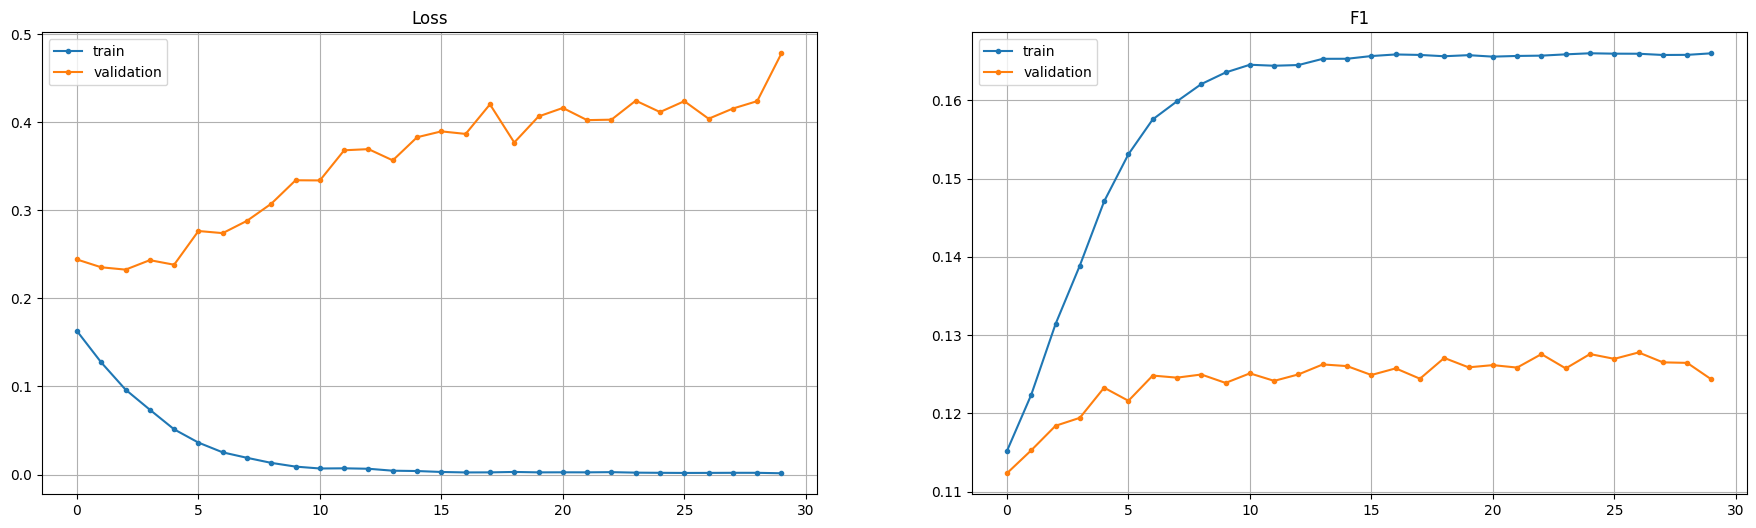

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

## Simple RNN

In [ ]:
torch.manual_seed(42)
model_rnn = NER_RNN(len(vocab), 512, 512, 3, len(targets))
model_rnn = model_rnn.to(device)
print(model_rnn)
print("Number of trainable parameters -", sum(p.numel() for p in model_rnn.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_rnn.parameters(), lr=1e-4)

NER_RNN(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): RNN(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 29916681


In [ ]:
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_rnn, train_loader, validation_loader, criterion, optimizer, None, device, n_epochs=30)


Epoch  1/30
training:   1%|▍                                       | 2/169 [00:00<00:28,  5.94it/s, loss 1.4840]

<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:20<00:00,  8.24it/s, loss 0.3268]
      loss: 0.27186457605580605
        f1: [9.78445063e-01 8.86377912e-03 1.98186922e-04 3.85231755e-04
 6.37978318e-04 2.10079717e-03 0.00000000e+00 1.84414944e-03
 8.40551751e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.19it/s]
      loss: 0.2492446211122331
        f1: [9.75448258e-01 2.57223012e-02 0.00000000e+00 3.06044376e-04
 0.00000000e+00 4.97322112e-03 0.00000000e+00 2.93292527e-03
 1.91277735e-03]
🟢 Saved new best state! 🟢

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:18<00:00,  9.11it/s, loss 0.2349]
      loss: 0.18806663226093767
        f1: [9.82148625e-01 2.48961757e-02 1.78264121e-03 1.14526438e-03
 3.01167606e-03 7.30099228e-03 9.24556213e-05 3.84552578e-03
 4.11314706e-03]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.53it/s]
      los

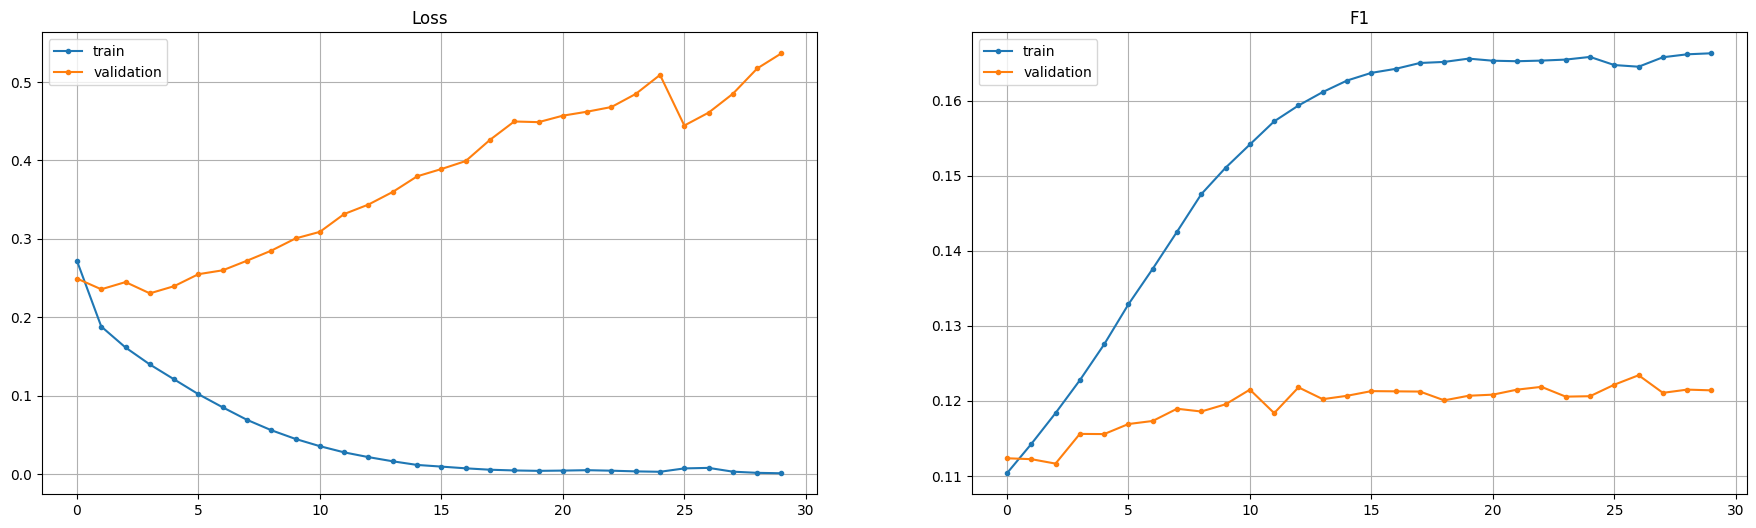

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

## LSTM

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-4)

NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, None, device, n_epochs=30)


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<00:51,  3.25it/s, loss 2.4896]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.38it/s, loss 0.2239]
      loss: 0.27977543681330935
        f1: [9.72218754e-01 0.00000000e+00 1.22444340e-04 0.00000000e+00
 6.74231772e-04 8.36547377e-05 0.00000000e+00 6.16370809e-05
 6.16370809e-05]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.65it/s]
      loss: 0.2695476318753901
        f1: [9.74487091e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.48136408e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
🟢 Saved new best state! 🟢

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.43it/s, loss 0.2044]
      loss: 0.19777052417485672
        f1: [9.81708752e-01 5.61418416e-03 1.12827085e-03 1.84911243e-04
 4.30599305e-03 2.58611581e-03 7.39644970e-05 5.23915187e-04
 2.93813537e-03]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00, 10.14it/s]
      los

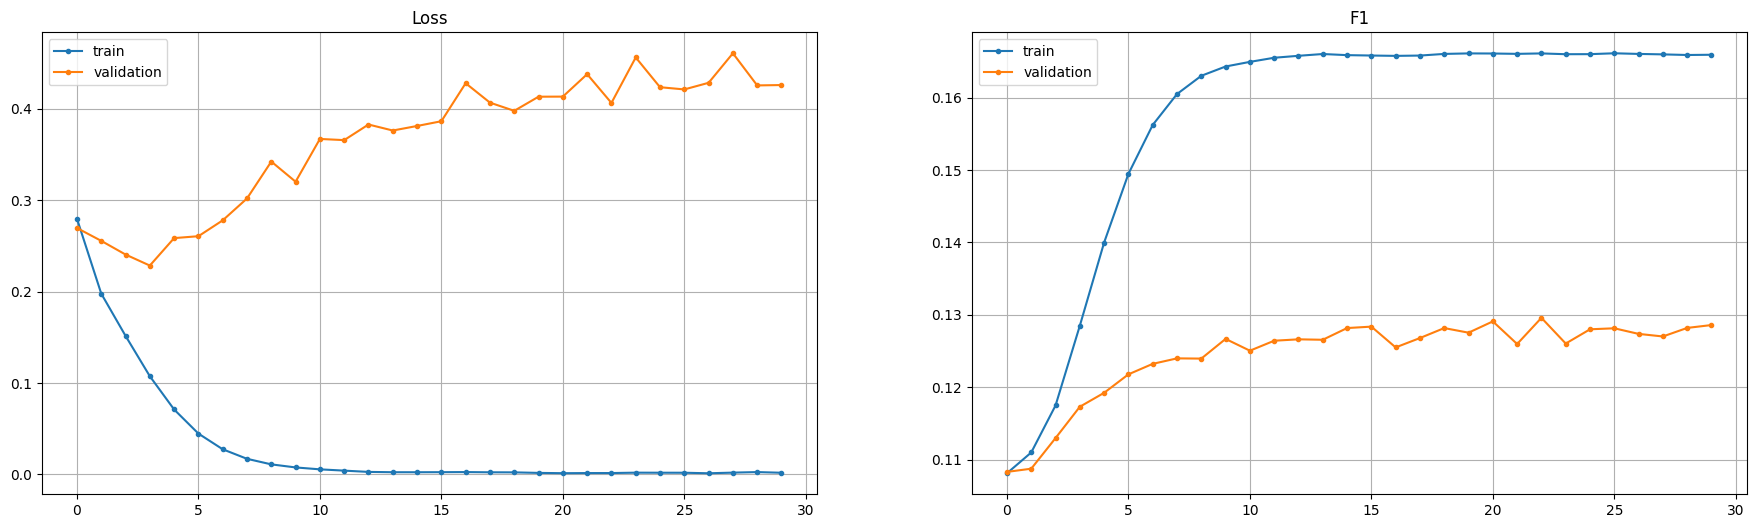

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

## Summary

In [ ]:
# gru
gru_val_scores = np.array([0.98106516, 0.10047389, 0.01644712, 0.01752104, 0.00769483, 0.01695096, 0.00255037, 0.00443764, 0.00295843])
# rnn
rnn_val_scores = np.array([0.97299704, 0.07927426, 0.01631318, 0.0124203, 0.00441214, 0.01415755, 0.00127518, 0.00765111, 0.00229533])
# lstm
lstm_val_scores = np.array([0.98102454, 0.10134678, 0.0186641,  0.01820964, 0.00742158, 0.01970586, 0.00331548, 0.0110431,  0.00558299])

print(f"Mean GRU: {np.mean(gru_val_scores)}, Mean RNN: {np.mean(rnn_val_scores)}, Mean LSTM: {np.mean(lstm_val_scores)}")

Mean GRU: 0.12778882666666666, Mean RNN: 0.12342178777777778, Mean LSTM: 0.12959045222222224


### The best is LSTM - the most complex one. The principle of "stack more layers" is applicable here due to the complex relationships in our model. We will stick with it and tune it further.

## Learning rate scheduler
### RNNs have not addressed the issue of a gradient decay, but plots do not reflect any plain lines, then there is no decay. Consequently, we take the best model and add a learning rate scheduler to get a better understanding of the loss function surface and if the peak performance has reached after the fine-tuning, it will be most likely due to the limitation in data and/or model.

### Tasks often utilizes the ReduceLROnPlateau to fine-tune the model, when the score at its peak and we are looking for a better-fit local minimum with extremely small (and/or different) steps to avoid overshooting (it might've been the case since we only tried limited parameters).

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=3, verbose=True)

NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=30)


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<00:56,  2.96it/s, loss 2.4896]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:37<00:00,  4.48it/s, loss 0.2239]
      loss: 0.27977543681330935
        f1: [9.72218754e-01 0.00000000e+00 1.22444340e-04 0.00000000e+00
 6.74231772e-04 8.36547377e-05 0.00000000e+00 6.16370809e-05
 6.16370809e-05]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.45it/s]
      loss: 0.2695476318753901
        f1: [9.74487091e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.48136408e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
🟢 Saved new best state! 🟢

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.44it/s, loss 0.2044]
      loss: 0.19777052417485672
        f1: [9.81708752e-01 5.61418416e-03 1.12827085e-03 1.84911243e-04
 4.30599305e-03 2.58611581e-03 7.39644970e-05 5.23915187e-04
 2.93813537e-03]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.81it/s]
      los

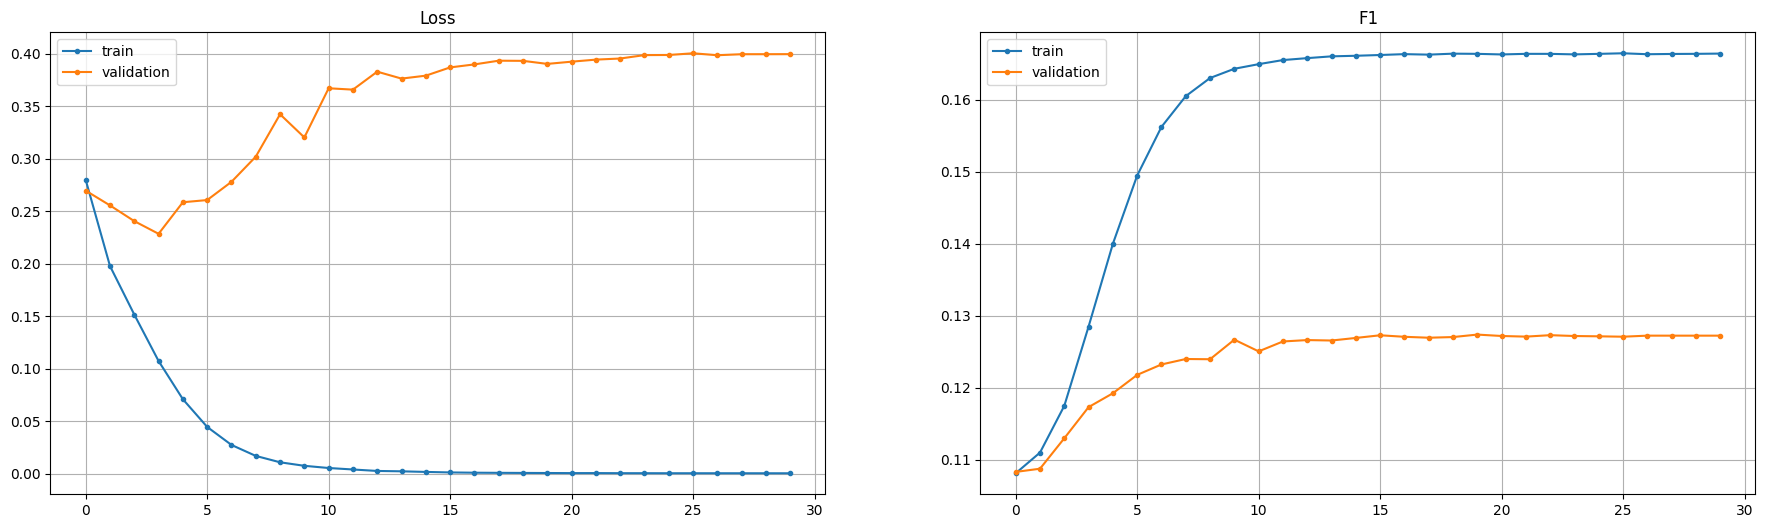

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

In [49]:
np.mean([0.98173272, 0.1019485,  0.01325165, 0.01509819, 0.00575655, 0.0186087, 0.00178526, 0.00535578, 0.00293293])

0.12738558666666666

### It definitely wasn't an overshoot because it reflects the pattern of the vanishing gradient or plateau. Now, we can be more certain it was an overshoot (the scores are also worse here). Let's make sure at last.

### It seems to have stopped improving after the 15th epoch, then we will change the code accordingly to only consider using the scheduler only from the 15th epoch.

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=3, verbose=True)

NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
n_epochs = 30

train_losses = []
train_scores = []

valid_losses = []
valid_scores = []

best_score = float("-inf")

for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    train_logs = train_one_epoch(model_lstm, train_loader, criterion, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["losses"]))
    train_scores.append(np.mean(train_logs["f1"], 0))
    print("      loss:", train_losses[-1])
    print("        f1:", train_scores[-1])


    valid_logs = evaluate(model_lstm, validation_loader, criterion, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_scores.append(np.mean(valid_logs["f1"], 0))
    print("      loss:", valid_losses[-1])
    print("        f1:", valid_scores[-1])

    if valid_scores[-1].mean() >= best_score:
        checkpoint = {
            "model_state_dict": model_lstm.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": ep,
            "num_epochs": n_epochs,
            "metrics": {
                "training": {"loss": train_losses[-1], "accuracy": train_scores[-1]},
                "validation": {"loss": valid_losses[-1], "accuracy": valid_scores[-1]},
            },
        }
        torch.save(checkpoint, "best_lstm.pth")
        print("🟢 Saved new best state! 🟢")
        best_score = valid_scores[-1].mean()  # update best score to a new one

    if ep >=15: # <--------------------------------------- Here is the key
      scheduler.step(valid_scores[-1].mean())


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<00:59,  2.84it/s, loss 2.4896]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.41it/s, loss 0.2239]
      loss: 0.27977543681330935
        f1: [9.72218754e-01 0.00000000e+00 1.22444340e-04 0.00000000e+00
 6.74231772e-04 8.36547377e-05 0.00000000e+00 6.16370809e-05
 6.16370809e-05]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.38it/s]
      loss: 0.2695476318753901
        f1: [9.74487091e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.48136408e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
🟢 Saved new best state! 🟢

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:40<00:00,  4.20it/s, loss 0.2044]
      loss: 0.19777052417485672
        f1: [9.81708752e-01 5.61418416e-03 1.12827085e-03 1.84911243e-04
 4.30599305e-03 2.58611581e-03 7.39644970e-05 5.23915187e-04
 2.93813537e-03]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.98it/s]
      los

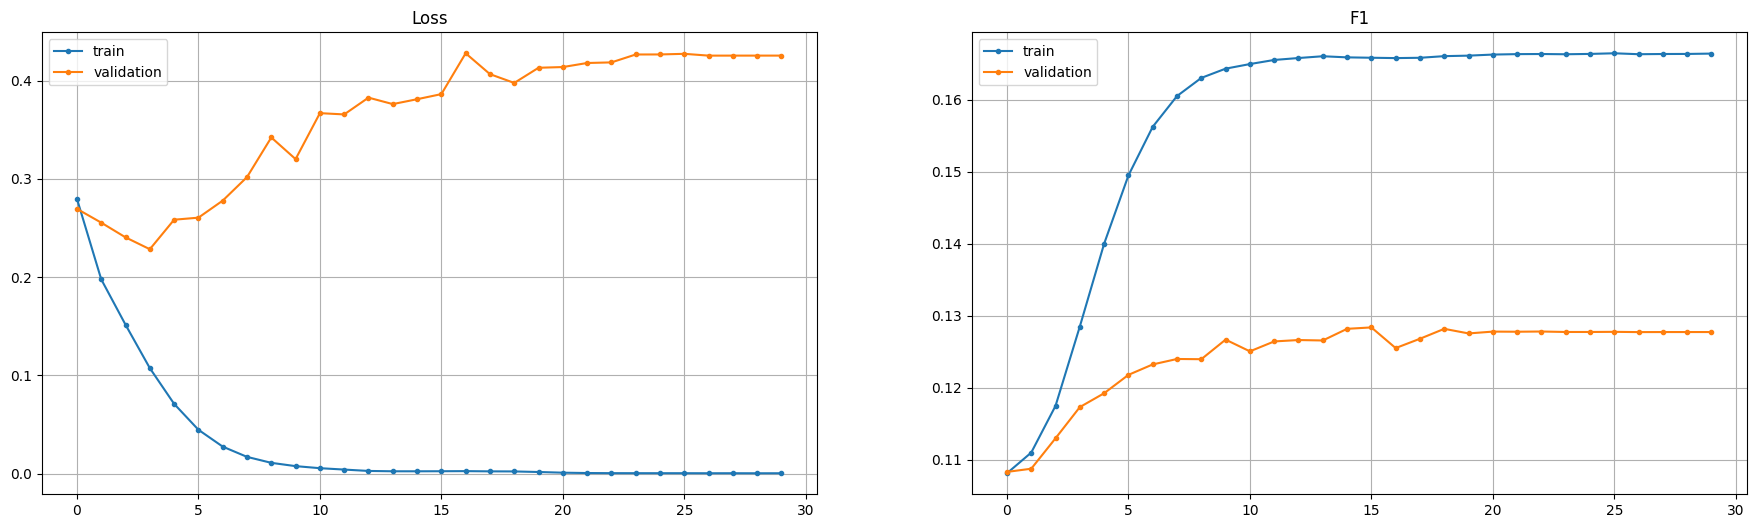

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

In [48]:
np.mean(np.array([0.98143631, 0.10356031, 0.0137953, 0.02132109, 0.00791343, 0.01573578, 0.0020403, 0.00586585, 0.00372122]))

0.12837662111111114

### Still stuck, let's change the scheduler to the OneCycleLR. It has both a peak and a decay phase. It may help us get out of that very surface we are at. It looks similarly to this. We do not start over, we add 5 more epochs to the previous 30 epochs and see what happens:



In [ ]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 1e-2, total_steps=5)

In [ ]:
import copy

n_epochs = 5

model_test = copy.deepcopy(model_lstm)

train_losses_test = copy.copy(train_losses)
train_scores_test = copy.copy(train_scores)

valid_losses_test = copy.copy(valid_losses)
valid_scores_test = copy.copy(valid_scores)

for ep in range(30, 30+n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs+30:2d}")

    train_logs = train_one_epoch(model_lstm, train_loader, criterion, optimizer, device, verbose=True)
    train_losses_test.append(np.mean(train_logs["losses"]))
    train_scores_test.append(np.mean(train_logs["f1"], 0))
    print("      loss:", train_losses_test[-1])
    print("        f1:", train_scores_test[-1])


    valid_logs = evaluate(model_lstm, validation_loader, criterion, device, verbose=True)
    valid_losses_test.append(np.mean(valid_logs["losses"]))
    valid_scores_test.append(np.mean(valid_logs["f1"], 0))
    print("      loss:", valid_losses_test[-1])
    print("        f1:", valid_scores_test[-1])

    if valid_scores_test[-1].mean() >= best_score:
        checkpoint = {
            "model_state_dict": model_lstm.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": ep,
            "num_epochs": n_epochs,
            "metrics": {
                "training": {"loss": train_losses_test[-1], "accuracy": train_scores_test[-1]},
                "validation": {"loss": valid_losses_test[-1], "accuracy": valid_scores_test[-1]},
            },
        }
        print("🟢 New best state! 🟢")
        #best_score = valid_scores_test[-1].mean()  # update best score to a new one

    scheduler.step(valid_scores_test[-1].mean())


Epoch 31/35
training:   1%|▏                                       | 1/169 [00:00<00:46,  3.59it/s, loss 0.0340]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:42<00:00,  3.96it/s, loss 0.0106]
      loss: 0.03253679760571944
        f1: [0.99653382 0.21104859 0.04106612 0.02698193 0.01818826 0.0743651
 0.0159547  0.0258479  0.01501591]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.77it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      loss: 0.2805187538975761
        f1: [0.98120423 0.11130309 0.01629166 0.00642693 0.00475644 0.0186432
 0.00229533 0.00765111 0.00377455]

Epoch 32/35
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.42it/s, loss 0.0535]
      loss: 0.05626615687526939
        f1: [0.99348498 0.18453168 0.03515249 0.02003734 0.0151601  0.05904374
 0.01239805 0.02168304 0.01223869]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.46it/s]
      loss: 0.22177654930523463
        f1: [0.97925719 0.11140554 0.01724884 0.01027799 0.00608462 0.02100867
 0.00280541 0.00898095 0.00719569]
🟢 New best state! 🟢

Epoch 33/35
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.42it/s, loss 0.0094]
      loss: 0.026359440067220897
        f1: [0.99703686 0.21071856 0.0417175  0.02916083 0.01952974 0.07611994
 0.01679094 0.02997815 0.0173982 ]
evaluation: 100%|██████████████████████████████████████████████████

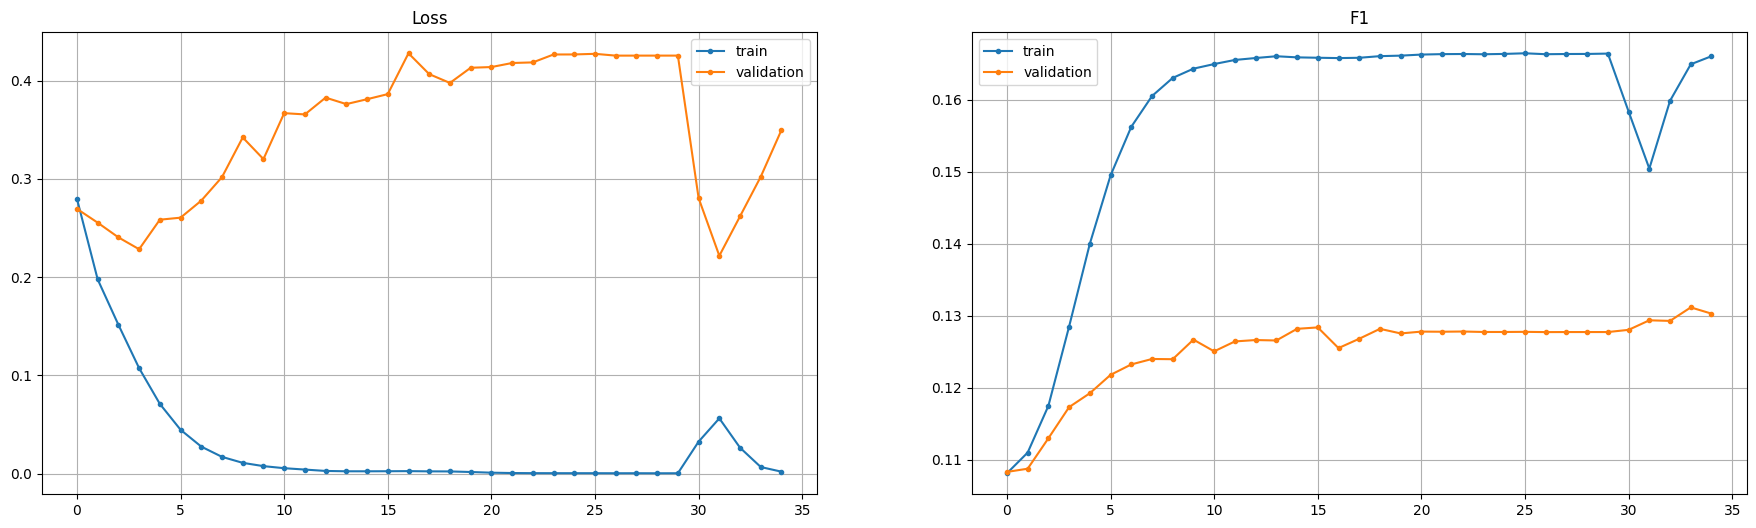

In [ ]:
plot_loss_and_f1_scores(train_losses_test, valid_losses_test, train_scores_test, valid_scores_test)

In [ ]:
np.mean(np.array([0.98196118, 0.12056488, 0.01475005, 0.01634787, 0.00870769, 0.02013892, 0.00229533, 0.00497322, 0.00286006]))

0.13028879999999998

### Great! We have got out of the plateau. Let us see what happens if we apply the OncecycleLR from the very beginning:

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 1e-2, total_steps=30)

NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=30)


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<00:50,  3.34it/s, loss 2.4896]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.44it/s, loss 0.1910]
      loss: 0.2518245806179103
        f1: [9.75151419e-01 1.74546392e-03 4.68307089e-04 0.00000000e+00
 1.60812396e-03 8.29903681e-04 0.00000000e+00 0.00000000e+00
 2.94830703e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 10.59it/s]
      loss: 0.23701912483998708
        f1: [0.97525426 0.0179546  0.         0.         0.00294568 0.00139289
 0.         0.         0.        ]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


🟢 Saved new best state! 🟢

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.42it/s, loss 0.1466]
      loss: 0.1515041038658492
        f1: [0.98501066 0.076898   0.00701601 0.00311561 0.00654623 0.0161501
 0.0010628  0.00498798 0.00641731]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.51it/s]
      loss: 0.20698152606685957
        f1: [9.78096633e-01 6.44304343e-02 5.19378607e-03 3.69803622e-03
 2.69428353e-03 1.38375779e-02 5.10073961e-04 0.00000000e+00
 0.00000000e+00]
🟢 Saved new best state! 🟢

Epoch  3/30
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.41it/s, loss 0.0451]
      loss: 0.07050936881827533
        f1: [0.99247707 0.16728889 0.02992125 0.01362107 0.01445182 0.0450066
 0.00791771 0.01327082 0.01137416]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.47it/s]
      loss: 0.21616139564485776
        f1: [9

KeyboardInterrupt: ignored

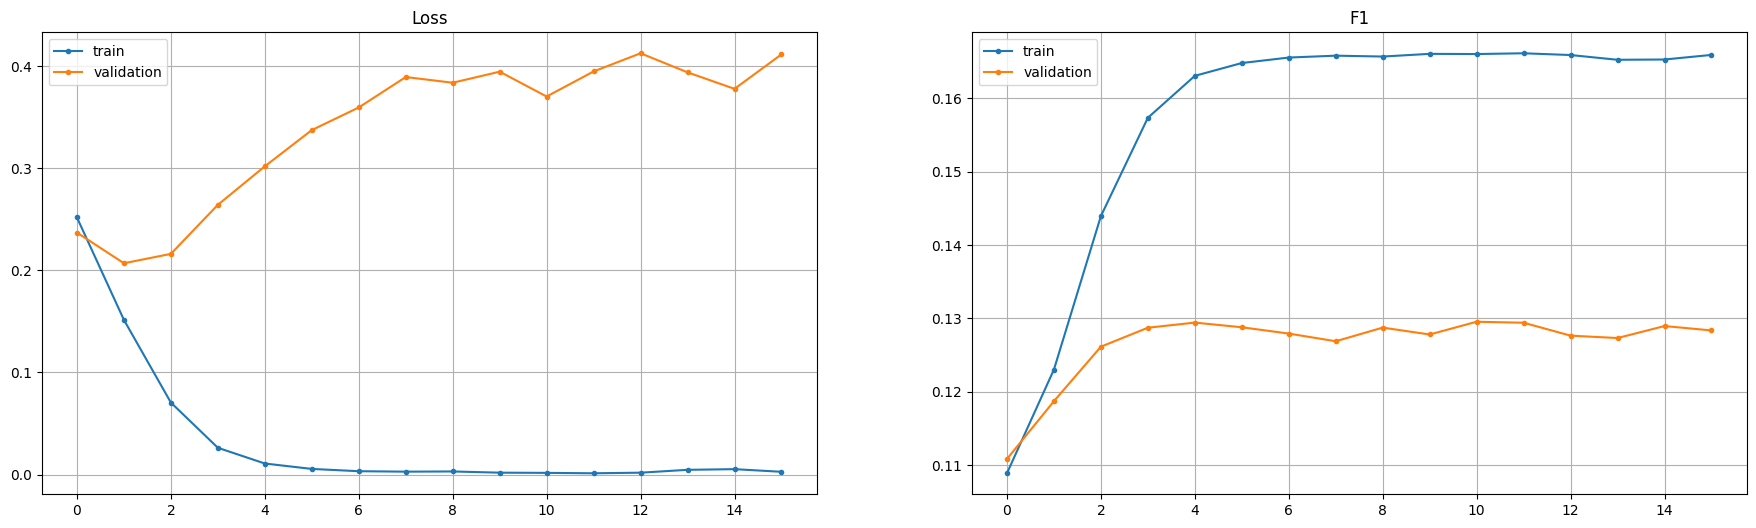

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

### Thought I woud be able to judge, but too soon. Continue

In [ ]:
n_epochs = 14

for ep in range(16, 30):
    print(f"\nEpoch {ep + 1:2d}/{30:2d}")

    train_logs = train_one_epoch(model_lstm, train_loader, criterion, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["losses"]))
    train_scores.append(np.mean(train_logs["f1"], 0))
    print("      loss:", train_losses[-1])
    print("        f1:", train_scores[-1])


    valid_logs = evaluate(model_lstm, validation_loader, criterion, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_scores.append(np.mean(valid_logs["f1"], 0))
    print("      loss:", valid_losses[-1])
    print("        f1:", valid_scores[-1])

    if valid_scores[-1].mean() >= best_score:
        checkpoint = {
            "model_state_dict": model_lstm.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": ep,
            "num_epochs": n_epochs,
            "metrics": {
                "training": {"loss": train_losses[-1], "accuracy": train_scores[-1]},
                "validation": {"loss": valid_losses[-1], "accuracy": valid_scores[-1]},
            },
        }
        torch.save(checkpoint, "best_lstm.pth")
        print("🟢 Saved new best state! 🟢")
        best_score = valid_scores[-1].mean()  # update best score to a new one

    scheduler.step(valid_scores[-1].mean())


Epoch 17/30
training:   1%|▏                                       | 1/169 [00:00<00:30,  5.59it/s, loss 0.0002]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.42it/s, loss 0.0012]
      loss: 0.0015850020771878551
        f1: [0.99979325 0.22440208 0.04752659 0.03610818 0.02414936 0.08419317
 0.02081344 0.03599811 0.02021259]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.50it/s]
      loss: 0.40743908073220936
        f1: [0.9804542  0.11743648 0.01777522 0.0185922  0.00785332 0.01879623
 0.00255037 0.006886   0.00153022]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


🟢 Saved new best state! 🟢

Epoch 18/30
training: 100%|██████████████████████████████████████| 169/169 [00:39<00:00,  4.27it/s, loss 0.0013]
      loss: 0.0008279842777590914
        f1: [0.99988455 0.22519019 0.04764546 0.03594675 0.02418437 0.08454582
 0.02094545 0.03661243 0.02051674]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  8.12it/s]
      loss: 0.4389242636305945
        f1: [0.9814913  0.11599052 0.01666518 0.0179546  0.00685442 0.01909377
 0.00255037 0.00510074 0.00229533]

Epoch 19/30
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.43it/s, loss 0.0022]
      loss: 0.0009078240785522169
        f1: [0.99991232 0.22525301 0.04759615 0.03618009 0.02424913 0.08442431
 0.0208847  0.03650148 0.02052515]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.91it/s]
      loss: 0.44220927606026333
        f1: [0.98184521 0.11592214 0.01908386 0.00655445 0.00543047 0.0

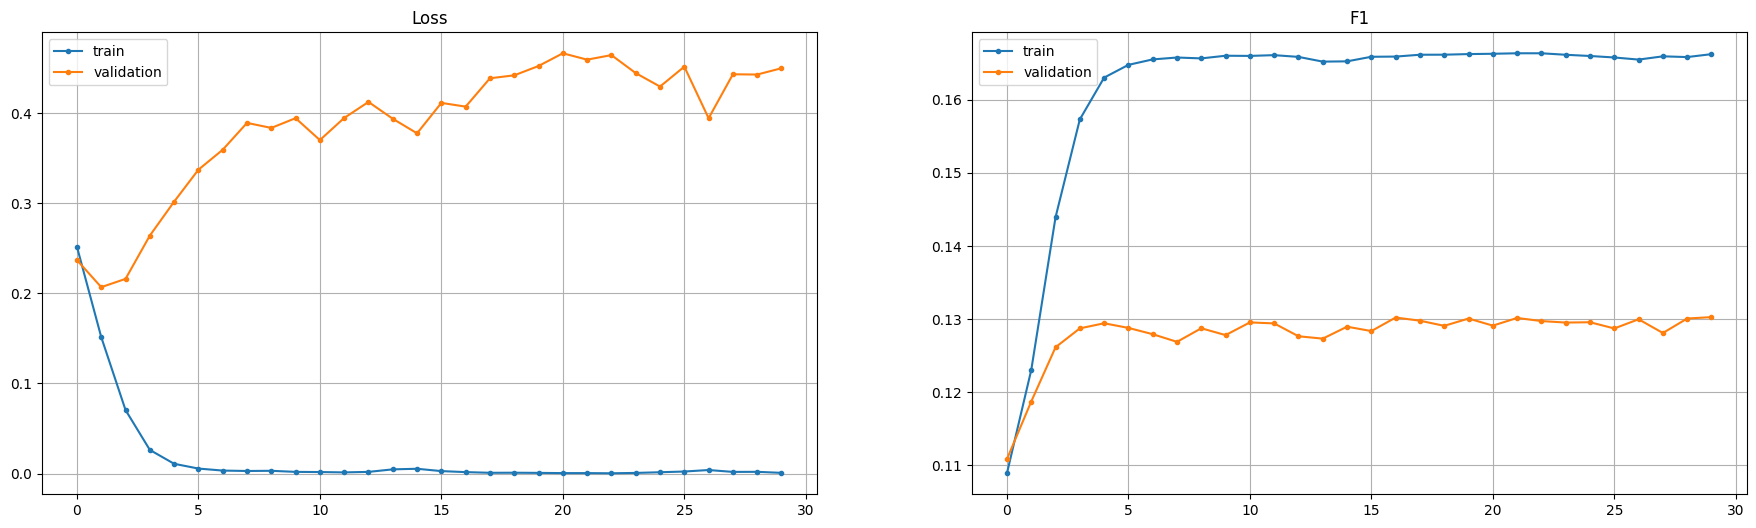

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

In [ ]:
np.mean(np.array([0.9825312,  0.11433846, 0.02667866, 0.01068605, 0.0066559,  0.02177882,0.00229533, 0.00612089, 0.00127518]))

0.13026227666666668

### The scheduler starts too low, the results are slightly worse again. We change it to the CosineAnnealingLR that has a similar shape, but starts immediately from the peak.

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
n_epochs = 30

train_losses = []
train_scores = []

valid_losses = []
valid_scores = []

best_score = float("-inf")

for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    train_logs = train_one_epoch(model_lstm, train_loader, criterion, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["losses"]))
    train_scores.append(np.mean(train_logs["f1"], 0))
    print("      loss:", train_losses[-1])
    print("        f1:", train_scores[-1])


    valid_logs = evaluate(model_lstm, validation_loader, criterion, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_scores.append(np.mean(valid_logs["f1"], 0))
    print("      loss:", valid_losses[-1])
    print("        f1:", valid_scores[-1])

    if valid_scores[-1].mean() >= best_score:
        checkpoint = {
            "model_state_dict": model_lstm.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": ep,
            "num_epochs": n_epochs,
            "metrics": {
                "training": {"loss": train_losses[-1], "accuracy": train_scores[-1]},
                "validation": {"loss": valid_losses[-1], "accuracy": valid_scores[-1]},
            },
        }
        torch.save(checkpoint, "best_lstm.pth")
        print("🟢 Saved new best state! 🟢")
        best_score = valid_scores[-1].mean()  # update best score to a new one

    if ep >=15:
      scheduler.step(valid_scores[-1].mean())


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<00:58,  2.88it/s, loss 2.4896]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.40it/s, loss 0.1741]
      loss: 0.2339672984985205
        f1: [9.75726943e-01 1.98551315e-02 1.00933866e-03 0.00000000e+00
 1.23963910e-03 4.77335606e-03 0.00000000e+00 1.18871513e-03
 6.69350942e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.37it/s]
      loss: 0.21306010034112705
        f1: [0.97662393 0.05426491 0.00281998 0.         0.00262445 0.00741065
 0.         0.         0.        ]
🟢 Saved new best state! 🟢

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:39<00:00,  4.27it/s, loss 0.1461]
      loss: 0.1162073531976113
        f1: [0.98842042 0.13464551 0.02017341 0.00669314 0.00767335 0.03187167
 0.00218173 0.0060391  0.00619475]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.43it/s]
      loss: 0.18753168270701454
        f1: [0.98032165 0.09570187 0.01544978 0.0043

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


🟢 Saved new best state! 🟢

Epoch 17/30
training: 100%|██████████████████████████████████████| 169/169 [00:37<00:00,  4.45it/s, loss 0.0011]
      loss: 0.0017358437930179529
        f1: [0.99989106 0.22547765 0.04740812 0.03616673 0.02411524 0.08469063
 0.02056169 0.03612725 0.02013948]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.02it/s]
      loss: 0.393631222702208
        f1: [0.98208269 0.11947344 0.02408579 0.0110431  0.00887048 0.02563122
 0.00331548 0.01020148 0.00435881]

Epoch 18/30
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.41it/s, loss 0.0099]
      loss: 0.0013608905059698255
        f1: [0.99988261 0.22542442 0.04756221 0.03600586 0.02391393 0.08422555
 0.02056991 0.03615631 0.02019495]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.09it/s]
      loss: 0.36795562009016675
        f1: [0.98026589 0.12114757 0.02515515 0.01415455 0.01086757 0.02

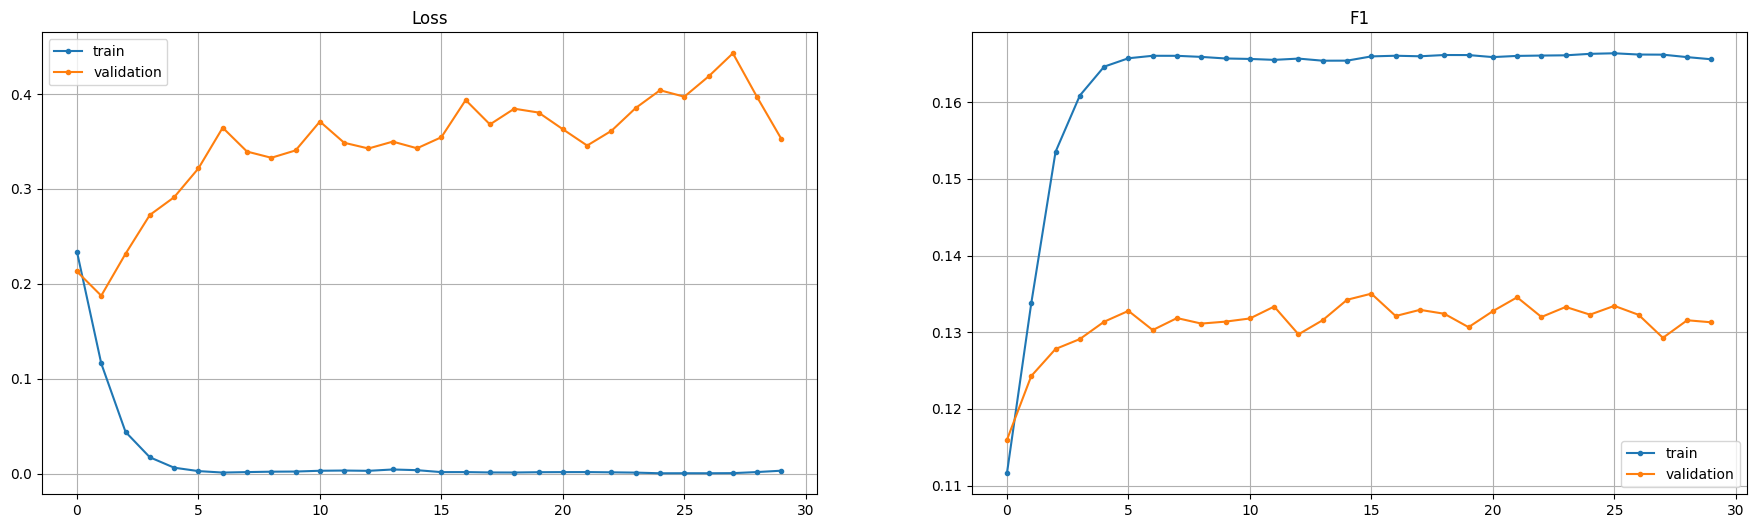

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

In [ ]:
np.mean(np.array([0.98235064, 0.13115757, 0.03112597, 0.01905126, 0.00772706, 0.02517215, 0.00306044, 0.01045652, 0.00518902]))

0.13503229222222224

### I actually forgot to remove the condition of applying the LRscheduler from the 15th epoch and the results are surprisingly good! I still tried to address the previous idea and it was worse than this mistake.

### The next assumption is a MultiStepLR. Assuming we have a very complex and irregular loss function surface we may benefit from its stair-like shape.

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15,20,25,30], gamma=.5)


NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=30)


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<00:53,  3.13it/s, loss 2.4896]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.36it/s, loss 0.1741]
      loss: 0.2339672984985205
        f1: [9.75726943e-01 1.98551315e-02 1.00933866e-03 0.00000000e+00
 1.23963910e-03 4.77335606e-03 0.00000000e+00 1.18871513e-03
 6.69350942e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.67it/s]
      loss: 0.21306010034112705
        f1: [0.97662393 0.05426491 0.00281998 0.         0.00262445 0.00741065
 0.         0.         0.        ]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


🟢 Saved new best state! 🟢 0.11597154644767417

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:37<00:00,  4.46it/s, loss 0.1461]
      loss: 0.1162073531976113
        f1: [0.98842042 0.13464551 0.02017341 0.00669314 0.00767335 0.03187167
 0.00218173 0.0060391  0.00619475]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.85it/s]
      loss: 0.18753168270701454
        f1: [0.98032165 0.09570187 0.01544978 0.00433563 0.00283091 0.01593981
 0.         0.00153022 0.00247582]
🟢 Saved new best state! 🟢 0.12428729928738834

Epoch  3/30
training: 100%|██████████████████████████████████████| 169/169 [00:44<00:00,  3.83it/s, loss 0.0378]
      loss: 0.04405641839040454
        f1: [0.99600053 0.20121337 0.04055081 0.01976199 0.01607943 0.06404431
 0.01254323 0.01869471 0.0128648 ]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.87it/s]
      loss: 0.23170810405697143
        f

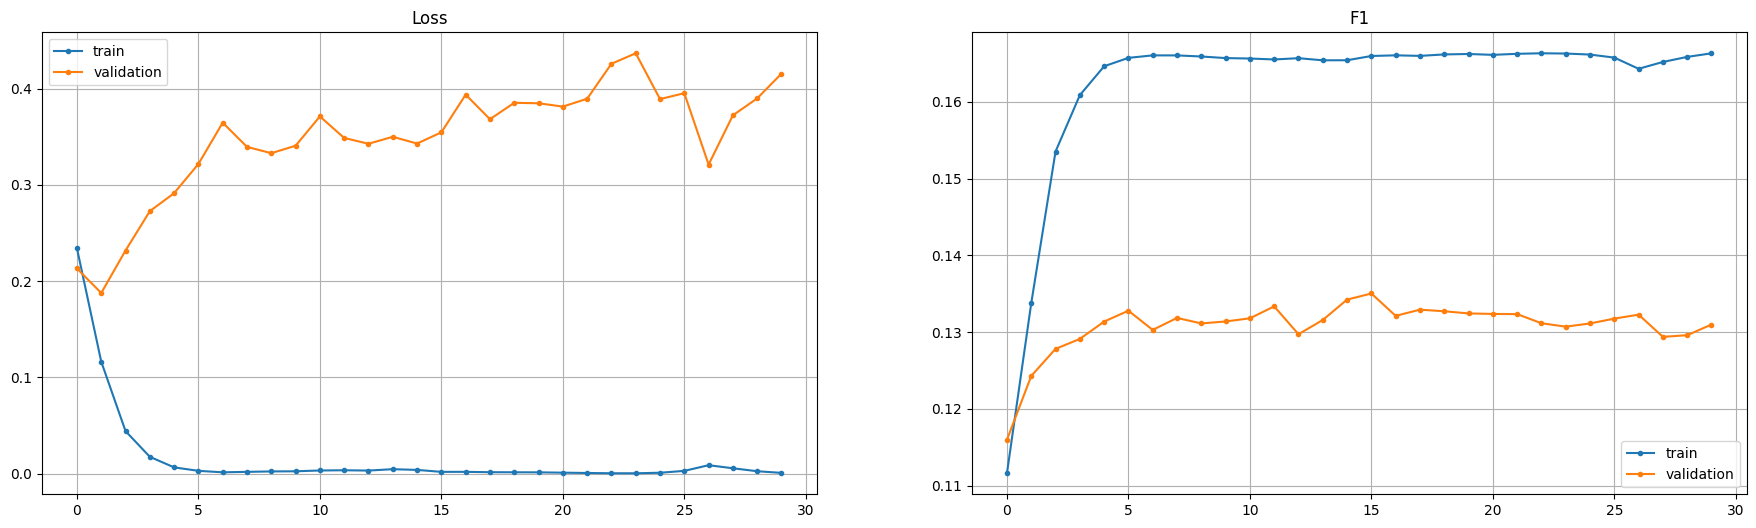

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

In [50]:
np.mean([0.98235064, 0.13115757, 0.03112597, 0.01905126, 0.00772706, 0.02517215, 0.00306044, 0.01045652, 0.00518902])

0.13503229222222224

### Apply the scheduler less frequently:

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,25], gamma=.5)


NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=30)


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<00:48,  3.47it/s, loss 2.4896]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:37<00:00,  4.45it/s, loss 0.1741]
      loss: 0.2339672984985205
        f1: [9.75726943e-01 1.98551315e-02 1.00933866e-03 0.00000000e+00
 1.23963910e-03 4.77335606e-03 0.00000000e+00 1.18871513e-03
 6.69350942e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.87it/s]
      loss: 0.21306010034112705
        f1: [0.97662393 0.05426491 0.00281998 0.         0.00262445 0.00741065
 0.         0.         0.        ]
🟢 Saved new best state! 🟢 0.11597154644767417

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.43it/s, loss 0.1461]
      loss: 0.1162073531976113
        f1: [0.98842042 0.13464551 0.02017341 0.00669314 0.00767335 0.03187167
 0.00218173 0.0060391  0.00619475]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.43it/s]
      loss: 0.18753168270701454
        f1: [0.98032165 0.095701

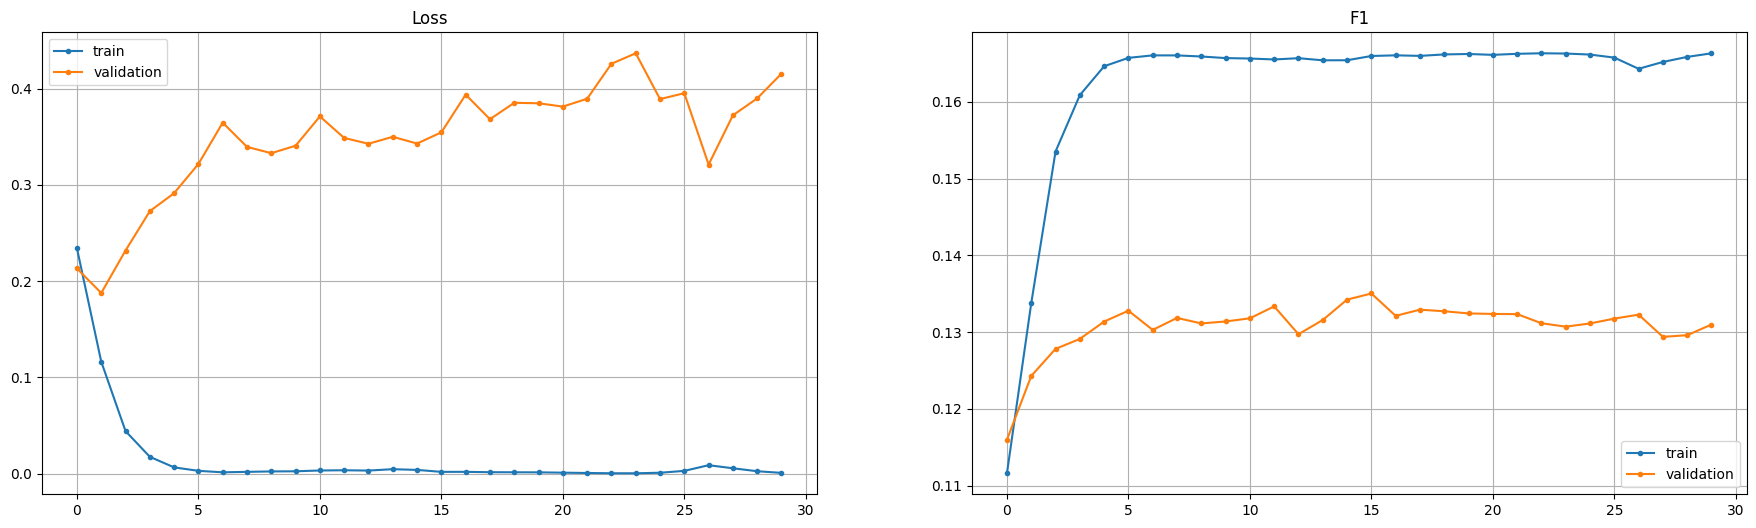

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

### 0.13503229298859626 - the best so far. Increasing learning rate even more:

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-2)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10], gamma=.5)


NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
# assuming it needs less epochs with higher learning rate
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=15)


Epoch  1/15
training:   1%|▏                                       | 1/169 [00:00<00:52,  3.22it/s, loss 2.4896]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:36<00:00,  4.60it/s, loss 0.2724]
      loss: 0.3410365973880305
        f1: [9.74915899e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.40309000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00, 10.35it/s]
      loss: 0.3088034632660094
        f1: [0.97440989 0.         0.         0.         0.         0.
 0.         0.         0.        ]
🟢 Saved new best state! 🟢 0.10826776513973238

Epoch  2/15
training: 100%|██████████████████████████████████████| 169/169 [00:37<00:00,  4.54it/s, loss 0.3781]
      loss: 0.2798061784378876
        f1: [0.98066456 0.         0.         0.         0.         0.
 0.         0.         0.        ]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.69it/s]
      loss: 0.30507470436749007
        f1: [0.97440989 0.         0.         0. 

KeyboardInterrupt: ignored

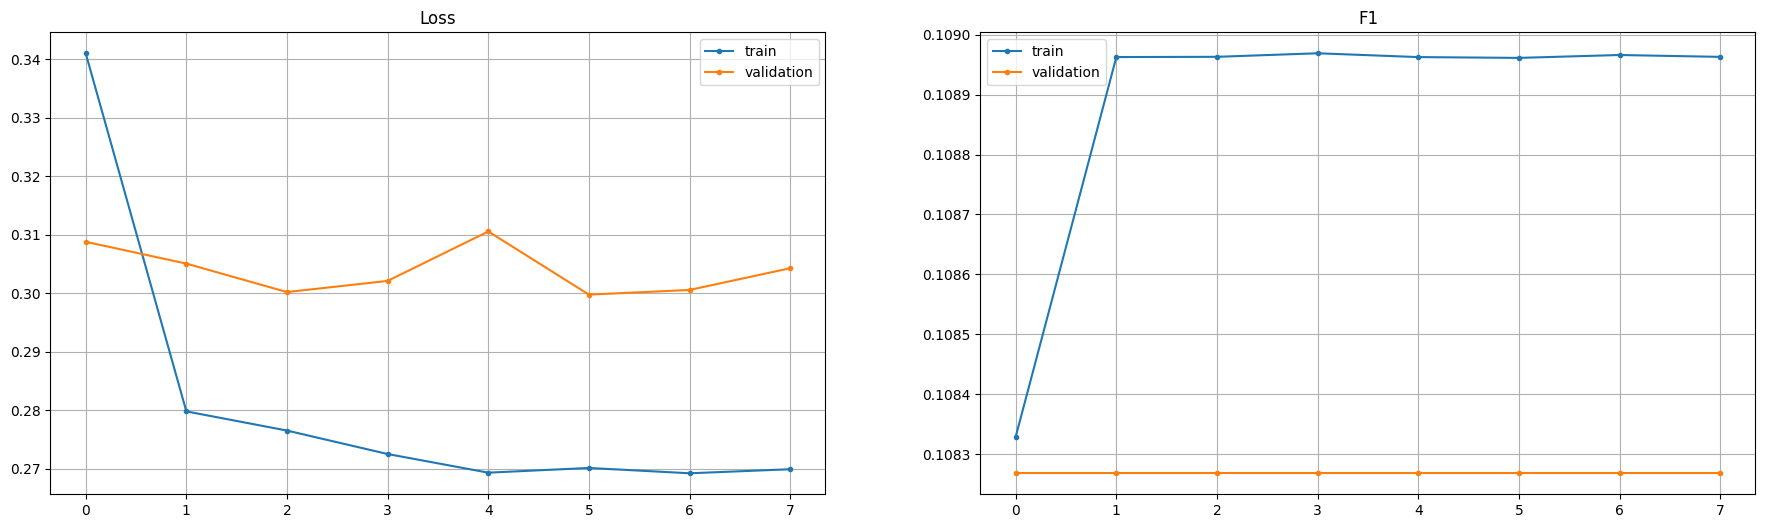

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

### Changing of the batch size to 128 was tried as an experiment, however was interrupted earlier due to over-generalizing:

In [ ]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=ner_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=.5)


NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=16)


Epoch  1/16
training:   1%|▍                                        | 1/84 [00:00<00:42,  1.93it/s, loss 2.5004]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|████████████████████████████████████████| 84/84 [00:41<00:00,  2.00it/s, loss 0.2940]
      loss: 0.2677227398824124
        f1: [9.69146483e-01 1.86011905e-04 3.54206113e-04 0.00000000e+00
 1.24723706e-03 8.68291035e-04 0.00000000e+00 9.30059524e-05
 4.34834390e-04]
evaluation: 100%|███████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.97it/s]
      loss: 0.24082308262586594
        f1: [0.97526008 0.02190768 0.         0.         0.00280723 0.
 0.         0.         0.        ]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


🟢 Saved new best state! 🟢 0.11110833160874482

Epoch  2/16
training: 100%|████████████████████████████████████████| 84/84 [00:42<00:00,  1.99it/s, loss 0.0849]
      loss: 0.15352919325232506
        f1: [9.84933590e-01 7.55378974e-02 6.19059119e-03 3.22430029e-03
 5.76869591e-03 1.48148148e-02 3.25520833e-04 4.91934384e-03
 5.75255327e-03]
evaluation: 100%|███████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.60it/s]
      loss: 0.20495676587928424
        f1: [9.78375448e-01 6.41767674e-02 1.01667842e-02 1.08172114e-02
 6.58260383e-03 1.23437898e-02 0.00000000e+00 5.10073961e-04
 2.03300907e-03]
🟢 Saved new best state! 🟢 0.12055618751431472

Epoch  3/16
training: 100%|████████████████████████████████████████| 84/84 [00:46<00:00,  1.80it/s, loss 0.0957]
      loss: 0.07269383762918767
        f1: [0.99267013 0.171931   0.03019041 0.01319761 0.01283644 0.04660422
 0.00633514 0.01165688 0.01062068]
evaluation: 100%|██████████████████████████████████████████████████

KeyboardInterrupt: ignored

### It was lowered to 32 and didn't help in increasing the score either:

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=ner_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)

In [ ]:
torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=.5)


NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025


In [ ]:
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=16)


Epoch  1/16
training:   0%|                                        | 1/338 [00:00<01:11,  4.68it/s, loss 2.4647]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 338/338 [00:38<00:00,  8.75it/s, loss 0.0652]
      loss: 0.20403039216245772
        f1: [0.98010294 0.05320978 0.00313899 0.00105399 0.00184488 0.01011686
 0.         0.00133415 0.00172884]
evaluation: 100%|███████████████████████████████████████████████████| 41/41 [00:01<00:00, 22.00it/s]
      loss: 0.19631617034717305
        f1: [9.77336399e-01 8.56651191e-02 4.49122415e-03 5.10073961e-04
 5.01068259e-03 1.18592196e-02 0.00000000e+00 6.63096149e-03
 0.00000000e+00]
🟢 Saved new best state! 🟢 0.12127818670252674

Epoch  2/16
training: 100%|██████████████████████████████████████| 338/338 [00:37<00:00,  9.05it/s, loss 0.1712]
      loss: 0.096747638123143
        f1: [0.99059708 0.16256086 0.02782139 0.00926031 0.00890889 0.04230578
 0.0056257  0.00901009 0.00761393]
evaluation: 100%|███████████████████████████████████████████████████| 41/41 [00:01<00:00, 21.99it/s]
      loss: 0.19768381164204785
        f1: [0.9803943  0.099521

In [ ]:
n_epochs = 14

for ep in range(16, 30):
    print(f"\nEpoch {ep + 1:2d}/{30:2d}")

    train_logs = train_one_epoch(model_lstm, train_loader, criterion, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["losses"]))
    train_scores.append(np.mean(train_logs["f1"], 0))
    print("      loss:", train_losses[-1])
    print("        f1:", train_scores[-1])


    valid_logs = evaluate(model_lstm, validation_loader, criterion, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_scores.append(np.mean(valid_logs["f1"], 0))
    print("      loss:", valid_losses[-1])
    print("        f1:", valid_scores[-1])

    if valid_scores[-1].mean() >= best_score:
        checkpoint = {
            "model_state_dict": model_lstm.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": ep,
            "num_epochs": n_epochs,
            "metrics": {
                "training": {"loss": train_losses[-1], "accuracy": train_scores[-1]},
                "validation": {"loss": valid_losses[-1], "accuracy": valid_scores[-1]},
            },
        }
        torch.save(checkpoint, "best_lstm.pth")
        print("🟢 Saved new best state! 🟢", valid_scores[-1].mean())
        best_score = valid_scores[-1].mean()  # update best score to a new one

    scheduler.step(valid_scores[-1].mean())


Epoch 17/30
training:   0%|                                                | 0/338 [00:00<?, ?it/s, loss 0.0056]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)


training: 100%|██████████████████████████████████████| 338/338 [00:37<00:00,  9.02it/s, loss 0.0003]
      loss: 0.001850336291660216
        f1: [0.99982265 0.22485002 0.0471717  0.03582964 0.02395817 0.08438645
 0.02077744 0.03630424 0.02035203]
evaluation: 100%|███████████████████████████████████████████████████| 41/41 [00:02<00:00, 16.02it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      loss: 0.3977550298157262
        f1: [0.98156583 0.11538708 0.02543957 0.01219077 0.00744387 0.02110806
 0.00306044 0.00918133 0.00311145]

Epoch 18/30
training: 100%|██████████████████████████████████████| 338/338 [00:37<00:00,  9.00it/s, loss 0.0168]
      loss: 0.002272636367325832
        f1: [0.99981608 0.22503985 0.04747288 0.03542396 0.02395845 0.08348038
 0.02054848 0.03549988 0.0200924 ]
evaluation: 100%|███████████████████████████████████████████████████| 41/41 [00:01<00:00, 22.90it/s]
      loss: 0.37590031271300667
        f1: [0.97990362 0.12666511 0.02509248 0.00976792 0.00693379 0.02410099
 0.00357052 0.00892629 0.0034175 ]

Epoch 19/30
training: 100%|██████████████████████████████████████| 338/338 [00:37<00:00,  9.12it/s, loss 0.0058]
      loss: 0.0037950893140438393
        f1: [0.99968027 0.22439199 0.04733728 0.03559365 0.02356659 0.08387985
 0.02027664 0.03612138 0.02004656]
evaluation: 100%|███████████████████████████████████████████████████| 41/41 [00:01<0

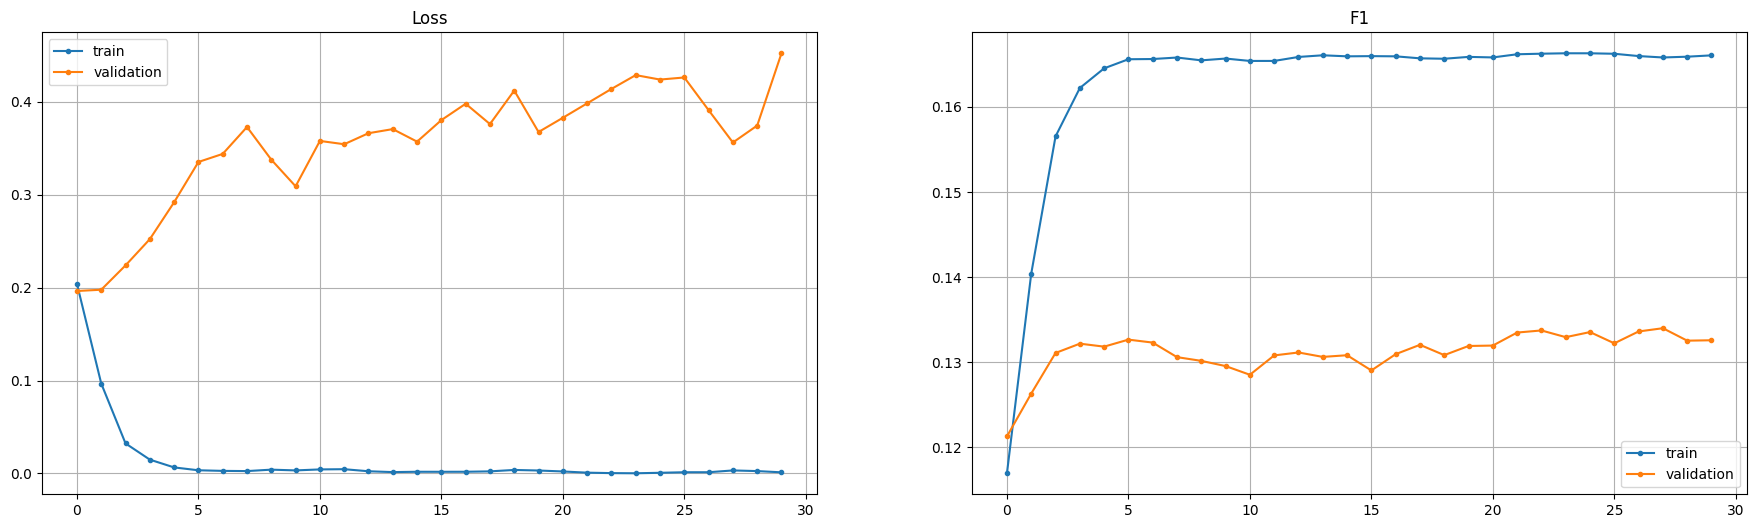

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

## Changing the best model complexity
### Since nothing has helped in increasing the score we can conclude the model is too simple for this data. Let's try to increase a number of hidden layers from 3 to 4.

In [ ]:
# saving the bes model:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=ner_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)

torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 512, 512, 4, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,25], gamma=.5)

train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=16)

NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 48817673

Epoch  1/16
training:   1%|▏                                       | 1/169 [00:00<01:02,  2.67it/s, loss 2.1718]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:54<00:00,  3.10it/s, loss 0.1701]
      loss: 0.2405017452567992
        f1: [9.75529523e-01 1.28338562e-02 6.00182608e-04 0.00000000e+00
 8.61683640e-04 2.61957594e-04 0.00000000e+00 3.66740631e-04
 9.53221783e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  8.57it/s]
      loss: 0.21592998859428225
        f1: [0.9767958  0.05256287 0.00149379 0.         0.00146646 0.00306044
 0.         0.         0.00279812]
🟢 Saved new best state! 🟢 0.11535305474454703

Epoch  2/16
training: 100%|██████████████████████████████████████| 169/169 [00:56<00:00,  3.00it/s, loss 0.1330]
      loss: 0.12563944272917404
        f1: [9.88622898e-01 1.29831125e-01 1.68993369e-02 3.30722257e-03
 6.23765154e-03 1.67088187e-02 4.62278107e-05 5.96991150e-03
 6.27160989e-03]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.68it/s]
      loss: 0.187002293765

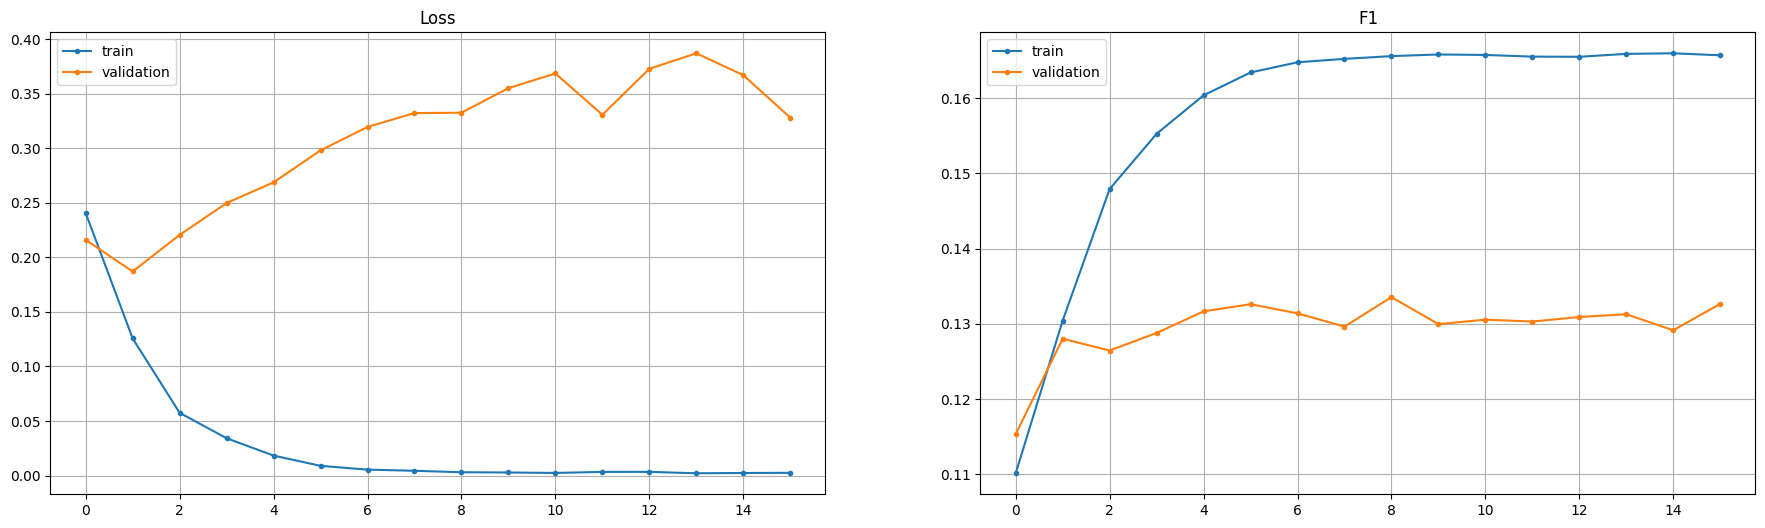

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

In [ ]:
for ep in range(16, 20):
    print(f"\nEpoch {ep + 1:2d}/{20:2d}")

    train_logs = train_one_epoch(model_lstm, train_loader, criterion, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["losses"]))
    train_scores.append(np.mean(train_logs["f1"], 0))
    print("      loss:", train_losses[-1])
    print("        f1:", train_scores[-1])


    valid_logs = evaluate(model_lstm, validation_loader, criterion, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_scores.append(np.mean(valid_logs["f1"], 0))
    print("      loss:", valid_losses[-1])
    print("        f1:", valid_scores[-1])

    if valid_scores[-1].mean() >= best_score:
        # checkpoint = {
        #     "model_state_dict": model_lstm.state_dict(),
        #     "optimizer_state_dict": optimizer.state_dict(),
        #     "epoch": ep,
        #     "num_epochs": n_epochs,
        #     "metrics": {
        #         "training": {"loss": train_losses[-1], "accuracy": train_scores[-1]},
        #         "validation": {"loss": valid_losses[-1], "accuracy": valid_scores[-1]},
        #     },
        # }
        # torch.save(checkpoint, "best_lstm.pth")
        print("🟢 Saved new best state! 🟢", valid_scores[-1].mean())
        best_score = valid_scores[-1].mean()  # update best score to a new one

    scheduler.step(valid_scores[-1].mean())


Epoch 17/20
training:   1%|▏                                       | 1/169 [00:00<00:53,  3.12it/s, loss 0.0001]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:52<00:00,  3.24it/s, loss 0.0038]
      loss: 0.0019922545046045115
        f1: [0.99980885 0.22482647 0.04754669 0.03601367 0.02411171 0.08435955
 0.02080251 0.03593134 0.0199057 ]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00, 10.15it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



      loss: 0.3669468377317701
        f1: [0.98156956 0.11651187 0.0180822  0.01081357 0.00698619 0.02330138
 0.00433563 0.01007396 0.0047364 ]

Epoch 18/20
training: 100%|██████████████████████████████████████| 169/169 [00:49<00:00,  3.44it/s, loss 0.0015]
      loss: 0.0027267370473453294
        f1: [0.99972878 0.22405923 0.04684212 0.03592018 0.02407272 0.08395293
 0.02065282 0.03643984 0.02032945]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00, 10.27it/s]
      loss: 0.3251990718500955
        f1: [0.98128671 0.11251128 0.02411134 0.01537873 0.00771305 0.02184767
 0.00438664 0.01025249 0.00320618]

Epoch 19/20
training: 100%|██████████████████████████████████████| 169/169 [00:52<00:00,  3.21it/s, loss 0.0011]
      loss: 0.004523121988378085
        f1: [0.99948497 0.22366949 0.04649771 0.03559079 0.02381167 0.08365168
 0.02027505 0.03596744 0.01988755]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00

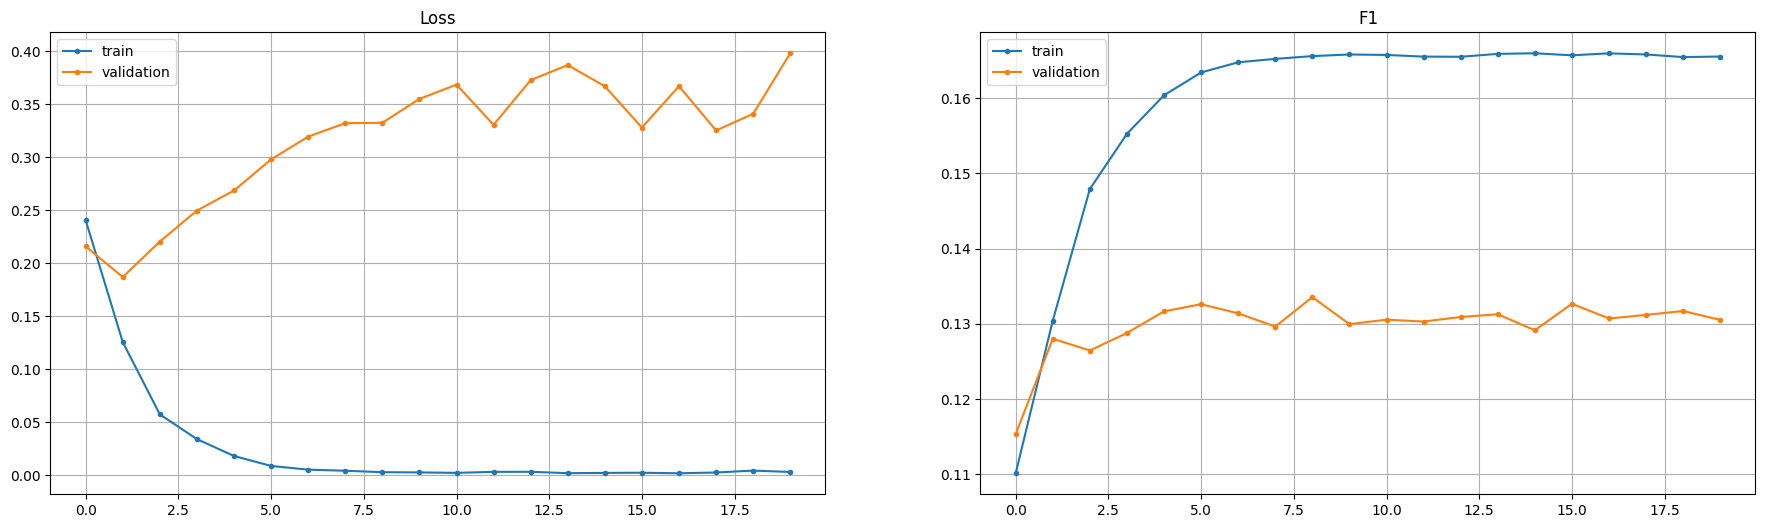

In [ ]:
plot_loss_and_f1_scores(train_losses, valid_losses, train_scores, valid_scores)

### The model has become too complex now, it is an overfit. Lowering the amount of neurons then 512 -> 256:

In [ ]:
# saving the bes model:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=ner_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)

torch.manual_seed(42)
model_lstm = NER_LSTM(len(vocab), 256, 256, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,25], gamma=.5)

train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=16)

NER_LSTM(
  (embed): Embedding(50205, 256, padding_idx=0)
  (rnn): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=512, out_features=9, bias=True)
)
Number of trainable parameters - 17064713

Epoch  1/16
training:   1%|▏                                       | 1/169 [00:00<00:38,  4.32it/s, loss 2.6741]

<ipython-input-11-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-11-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-11-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:20<00:00,  8.35it/s, loss 0.1684]
      loss: 0.2578764470547614
        f1: [9.75098295e-01 2.99690294e-03 2.05456936e-05 1.18871513e-04
 8.88307739e-04 7.79268808e-05 0.00000000e+00 1.23274162e-04
 7.44084794e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.09it/s]
      loss: 0.2465897560829208
        f1: [0.97539979 0.00238642 0.         0.         0.00367253 0.00139289
 0.         0.00290742 0.        ]
🟢 Saved new best state! 🟢 0.10952878449002826

Epoch  2/16
training: 100%|██████████████████████████████████████| 169/169 [00:19<00:00,  8.85it/s, loss 0.1262]
      loss: 0.15669238205844835
        f1: [9.84736264e-01 7.14128628e-02 4.66515210e-03 1.63338264e-03
 4.91120728e-03 1.60537579e-02 6.16370809e-04 5.39547925e-03
 5.65743830e-03]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 15.30it/s]
      loss: 0.1946135706135

### The loss went too high, assumption rejected.

## Conclusion
### We have achieved the best score of 0.135032 with the following parameters: LSTM model, batch of 64, 3 hidden layers, 512 neurons per layer, LR of 1e-3, lr_scheduler - MultiStepLR(...milestones=[15,25], gamma=.5) on the 16th epoch.

Below is presented the table of all moves and adjustments that were made in a shorter form:

Constant `batch_size`=`64`:

| LSTM                  | 1 | 2 |                                                       3 | 4|5|6|7|
|-----------------------|---|---|---------------------------------------------------------|--|--|--|--|
| LR scheduler          |ReduceLROnPlateau  | ReduceLROnPlateau + delay (15) | ReduceLROnPlateau + OneCycleLR | OneCycleLR |CosineAnnealingLR + delay (15)|MultiStepLR(mlsts=[5,10,15,20,25,30], gamma=.5)|MultiStepLR(mlsts=[15,25], gamma=.5)|
| Learning rate         | 1e-4  |   1e-4    | 1e-4                                        |1e-4|1e-3|1e-3|1e-3|
| Best epoch            | 20  | 16 |    35                                                |30 |16|16|16|
| test F1-score (mean)  | 0.12738  |    0.12837   | 0.130288                              |0.13026|0.13503|0.13503|<b>0.135032</b>|
| test loss (mean)      | 0.39018  |    0.386362    | 0.34989                             |0.45008|0.35447| 0.35447|0.35447|

Varying `batch_size`:

| LSTM                  | 1 |2|3|
|-----------------------|---|--|--|
| LR scheduler          |MultiStepLR(mlsts=[5,10], gamma=.5)  |MultiStepLR(mlsts=[5], gamma=.5)|MultiStepLR(mlsts=[15], gamma=.5)|
| Learning rate         | 1e-2  | 1e-3|1e-3|
| Best epoch            | -  | -|28|
|Batch size             |64  |128| 32|
| test F1-score (mean)  | interrupted  |interrupted|0.13399|
| test loss (mean)      | interrupted  |interrupted|0.35606|

Varying hidden layers:

| LSTM                  | 1 |2|
|-----------------------|---|---|
| LR scheduler          |MultiStepLR(mlsts=[15,25], gamma=.5)  |MultiStepLR(mlsts=[15,25], gamma=.5)|
| Learning rate         | 1e-3  |1e-3|
| Best epoch            | 9  |14|
|Batch size             |64  |64|
|Hidden layers          |4|3|
| test F1-score (mean)  | 0.13354  |0.12993|
| test loss (mean)      | 0.33244  |0.38274|

## Best model saving and testing

In [ ]:
# saving the best model:
# Set the batch size for data loading
batch_size = 64

# Create data loaders for training, validation, and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=ner_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)

# Set a manual seed for reproducibility
torch.manual_seed(42)

# Initialize the NER LSTM model with specified parameters
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
# Move the model to the specified device (e.g., GPU)
model_lstm = model_lstm.to(device)

# Print the model architecture
print(model_lstm)
# Print the total number of trainable parameters in the model
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))

# Define the loss function (cross-entropy loss) with padding index ignored
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Initialize the optimizer (Adam) for updating model parameters
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)

# Set up a learning rate scheduler to adjust the learning rate at specified milestones
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=.5)

# Train and validate the model, collecting losses and scores for each epoch
train_losses, train_scores, valid_losses, valid_scores = train_and_validate(model_lstm, train_loader, validation_loader, criterion, optimizer, scheduler, device, n_epochs=16)


NER_LSTM(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 42518025

Epoch  1/16
training:   1%|▏                                       | 1/169 [00:01<04:04,  1.46s/it, loss 2.4896]

<ipython-input-10-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-10-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-10-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.34it/s, loss 0.1741]
      loss: 0.2339672984985205
        f1: [9.75726943e-01 1.98551315e-02 1.00933866e-03 0.00000000e+00
 1.23963910e-03 4.77335606e-03 0.00000000e+00 1.18871513e-03
 6.69350942e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.55it/s]
      loss: 0.21306010034112705
        f1: [0.97662393 0.05426491 0.00281998 0.         0.00262445 0.00741065
 0.         0.         0.        ]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


🟢 Saved new best state! 🟢 0.11597154644767417

Epoch  2/16
training: 100%|██████████████████████████████████████| 169/169 [00:38<00:00,  4.37it/s, loss 0.1461]
      loss: 0.1162073531976113
        f1: [0.98842042 0.13464551 0.02017341 0.00669314 0.00767335 0.03187167
 0.00218173 0.0060391  0.00619475]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.08it/s]
      loss: 0.18753168270701454
        f1: [0.98032165 0.09570187 0.01544978 0.00433563 0.00283091 0.01593981
 0.         0.00153022 0.00247582]
🟢 Saved new best state! 🟢 0.12428729928738834

Epoch  3/16
training: 100%|██████████████████████████████████████| 169/169 [00:40<00:00,  4.13it/s, loss 0.0378]
      loss: 0.04405641839040454
        f1: [0.99600053 0.20121337 0.04055081 0.01976199 0.01607943 0.06404431
 0.01254323 0.01869471 0.0128648 ]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 11.33it/s]
      loss: 0.23170810405697143
        f

### Loading model's best state:

In [ ]:
# Load the saved checkpoint
checkpoint = torch.load("best_lstm.pth")

# Create a model instance with the same architecture as the saved model
model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))

# Load the model's state dictionary
model_lstm.load_state_dict(checkpoint["model_state_dict"], map_location=device)

<All keys matched successfully>

### Testing:

In [ ]:
# Set the model to evaluation mode
model_lstm.eval()

# Initialize lists to store scores and accuracies
scores = []
accuracies = []

# Iterate over batches in the test data loader
for x_batch, y_true in tqdm(test_loader, desc="test evaluation", file=sys.stdout, ncols=100, disable=not True):
    # Move input and true label tensors to the specified device (e.g., GPU)
    x_batch = x_batch.to(device)
    y_true = y_true.to(device)

    # Get log probabilities from the model for the current batch
    log_prob = model_lstm(x_batch)

    # Get predicted class indices by taking the argmax of the log probabilities
    y_pred = log_prob.argmax(2).detach().cpu().numpy()  # Convert to numpy array
    y_true = y_true.detach().cpu().numpy()  # Convert true labels to numpy array

    # Create a mask to ignore padding tokens in the true labels
    padding_mask = y_true != NER_PAD_ID

    # Iterate over each sample in the batch
    for i in range(x_batch.size(0)):
        # Calculate the F1 score for the current sample and append to scores
        scores.append(np.mean(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]])))

        # Calculate accuracy for the current sample
        correct_tokens = np.sum(y_true[i][padding_mask[i]] == y_pred[i][padding_mask[i]])  # Count correct predictions
        total_tokens = np.sum(padding_mask[i])  # Count total tokens excluding padding
        accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0.0  # Compute accuracy
        accuracies.append(accuracy)  # Append accuracy to the list

# Print the calculated accuracies and scores
print(f"Accuracies: {accuracies}")
print(f"Scores: {scores}")

Accuracies: [0.8888888888888888, 0.6, 0.95, 0.9375, 1.0, 0.8387096774193549, 1.0, 1.0, 0.65, 0.8461538461538461, 1.0, 1.0, 0.7894736842105263, 0.8648648648648649, 0.9019607843137255, 0.7931034482758621, 0.8235294117647058, 1.0, 0.95, 0.7333333333333333, 0.9166666666666666, 0.85, 1.0, 0.8378378378378378, 0.9090909090909091, 1.0, 1.0, 0.84375, 0.9375, 0.8846153846153846, 1.0, 1.0, 0.8620689655172413, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 0.9666666666666667, 1.0, 0.9411764705882353, 1.0, 0.9090909090909091, 1.0, 1.0, 0.9333333333333333, 0.8823529411764706, 0.7857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.75, 1.0, 0.9565217391304348, 1.0, 1.0, 0.8888888888888888, 0.9714285714285714, 1.0, 0.8666666666666667, 0.8571428571428571, 0.8958333333333334, 0.8823529411764706, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9387755102040817, 1.0, 0.9375, 0.9, 0.9130434782608695, 1.0, 0.8181818181818182, 0.7142857142857143, 0.9333333333333333, 0.9333333333333333,

In [29]:
print(len(accuracies))
print(len(scores))

668
668


In [31]:
print(f"Mean accuracy = {np.mean(accuracies)}")
print(f"Mean F1 score = {np.mean(scores)}")

Mean accuracy = 0.9521296358344278
Mean F1 score = 0.10816066139576676


## Improvements
### The model has shown its best performance with the imbalanced dataset like this. Possible improvements we may consider are:

- replace or add more data that is more balanced
- for any imbalances consider stratified cross-validation techniques
- simplification of the model and speed of convergence

### As the modifications mentioned above are not within the scope of the project, they are left to the observer as a puzzle.

## Conclusion

### The work over an imbalanced dataset was done. The project is composed from the environment selection, discovering its limitations; selecting the framework and dealing with the imbalanced dataset; proper encoding of data for an NLP task, discovering metrics, implementation strategies and practicing tuning deep learning parameters; schedulers. The final results do not surprise us with their scores due to being limited in resources and data. The final accuracy is 0.95212 and F1-score is 0.10816 that only highlights the validity of having chosen the metrics right. The model performs well, but lacks training samples for 1, 4, 5, 6, 7 and 8th classes severely. The project's objective was accomplished and the template created is valid for adjusting to other (better balanced) datasets preferably with the suggested improvements.

### Here are the parameters for the best model:
    batch_size = 64
    model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
    optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,25], gamma=.5)
    n_epochs = 16

    The final score: 0.13503229298859626